This code produces all figures as well as summary statistics reported in the main paper and supplement. It has to be run after the analysis code `COVID Regression Vengine v3`, using the same ControlFile and from the same folder; this code will read the output .tab files from the analysis, and will fail if they are not available. See main `Analysis Code` folder for `ReadMe` with explanation of ControlFile format and fields.

In [1]:
import os
import json
import regex
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
import matplotlib.cm as cm

from shutil import copy
from distutils.dir_util import copy_tree
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_fits_main(fits, mainfits, fitdict, ylabels, errmult=1.96):
    """Plot fit-to-data for six variables specified in `mainfits` list, 
    with names and y-labels from `fitdict` and `ylabels`, and error bars 
    where available of `errmult` x stderr"""
    
    # Define main figure and axes
    fig0, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(
        3, 2, figsize=[12, 12], sharex=True, constrained_layout=True)
    ax_list = [ax0, ax1, ax2, ax3, ax4, ax5]

    # Plot sim output, data, and error bars where available
    for ax, var in zip(ax_list, mainfits):
        ax.plot(fits.columns, fits.loc[f'SimVar[{var}]'], lw=2, zorder=10, label='Simulated')
#         ax.fill_between(sens.columns, sens.loc[f'SimVar[{var}]', 2.5], 
#                         sens.loc[f'SimVar[{var}]', 97.5], alpha=0.2)
        ax.scatter(fits.columns[::4], fits.loc[f'DataVar[{var}]'][::4], 
                   color='silver', label='Historical')
        try:
            ax.errorbar(fits.columns[::4], fits.loc[f'DataVar[{var}]'][::4], 
                        yerr=fits.loc[f'DataErr[{var}]'][::4] * errmult, fmt='o', 
                        color='silver', capsize=3, label='Historical')
        except KeyError: # Catch exception when DataErr not available
            pass
        ax.set_title(fitdict[var])
        
        ax.set_ylim(0) # Anchor y axis on 0
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))

    # Format X and Y axis for bottom two axes
    for ax in [ax4, ax5]:
        loc = mticker.MultipleLocator(base=8)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelsize=8, labelrotation=90)
        
        # Override Y-axis scientific notation
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    
    # Set labels for left-hand axes only, and figure title
    for ax, label in zip([ax0, ax2, ax4], ylabels):
        ax.set_ylabel(label)
    fig0.suptitle('Model fit to data for selected variables', fontsize=14)
    
    fig0.savefig(f"./{baserunname}_fits_main.jpg", bbox_inches='tight')
    

def plot_fits_proj(table, senstable, projfits, fitdict, bounds, ylabels, 
                   basevar='SimVar', endyear='2019'):
    """Plot projections for variables specified in `projfits` list, with 
    CIs specified in `bounds` (multiple CIs allowed) and names and y-
    labels from `fitdict` and `ylabels`; uses SimVar by default but can 
    set `basevar` to RepVar instead to show measurement noise"""
    t, s = table, senstable # For more compact code
    
    # Define main figure and axes
    fig0, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(
        3, 2, figsize=[12, 12], sharex=True, constrained_layout=True)
    ax_list = [ax0, ax1, ax2, ax3, ax4, ax5]

    # Plot sim output and CI bounds
    for ax, var in zip(ax_list, projfits):
        ax.plot(t.columns, t.loc[f'{basevar}[{var}]'])
        for bd in bounds:
            ax.fill_between(t.columns, s.loc[f'{basevar}[{var}]', bd[0]], 
                            s.loc[f'{basevar}[{var}]', bd[1]], alpha=0.2)
        ax.set_title(fitdict[var])
        
        # Add vertical dashed line to mark end of data
        ax.vlines(endyear, 0, 1, transform=ax.get_xaxis_transform(), color='r', ls='dashed')
        
        ax.set_ylim(0) # Anchor y axis on 0
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))

    # Format X and Y axis for bottom two axes
    for ax in [ax4, ax5]:
        loc = mticker.MultipleLocator(base=8)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelsize=8, labelrotation=90)
        
        # Override Y-axis scientific notation
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
        
    # Set labels for left-hand axes only, and figure title
    for ax, label in zip([ax0, ax2, ax4], ylabels):
        ax.set_ylabel(label)
    fig0.suptitle('Model base case projections for selected variables', fontsize=14)
    
    fig0.savefig(f"./{baserunname}_fits_proj.jpg", bbox_inches='tight')
    

def plot_fits_full(table, fullfits, fitdict):
    """Plot fit-to-data for all variables specified in `fullfits` list, 
    with names from `fitdict`"""
    
    # Define main figure and axes
    fig0, axs = plt.subplots(4, 4, figsize=[14, 10], sharex=True, constrained_layout=True)

    # Plot sim output and data
    for var, ax in zip(fullfits, axs.flatten()):
        ax.plot(table.loc[f'SimVar[{var}]'])
        ax.scatter(table.columns[::4], table.loc[f'DataVar[{var}]'][::4], color='silver')
        ax.set_title(fitdict[var], fontsize=9)

        loc = mticker.MultipleLocator(base=8)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelsize=7, labelrotation=90)

        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3))
        ax.yaxis.offsetText.set_fontsize(7)
        ax.tick_params(axis='y', labelsize=7)
    
    return fig0


def plot_fits_proj_full(table, senstable, fullfits, fitdict, 
                        bounds, basevar='SimVar', noisevar=None, endyear='2019'):
    """Plot projections for all variables specified in `fullfits` list, 
    with CIs specified in `bounds` (multiple CIs allowed) and names from 
    `fitdict`; show CIs without noise by default; show CIs with noise if 
    `noisevar` specified (usually as RepVar)"""
    t, s = table, senstable # For more compact code
    
    # Define main figure and axes
    fig0, axs = plt.subplots(4, 4, figsize=[14, 10], sharex=True, constrained_layout=True)
    
    # Plot sim output and CI bounds
    for ax, var in zip(axs.flatten(), fullfits):
        ax.plot(t.columns, t.loc[f'{basevar}[{var}]'])
        for bd in bounds:
            if noisevar: # Additionally show CIs for noise if specified
                ax.fill_between(t.columns, s.loc[f'{noisevar}[{var}]', bd[0]], 
                                s.loc[f'{noisevar}[{var}]', bd[1]], alpha=0.2, color='grey')
            ax.fill_between(t.columns, s.loc[f'{basevar}[{var}]', bd[0]], 
                            s.loc[f'{basevar}[{var}]', bd[1]], alpha=0.2)
        ax.set_title(fitdict[var], fontsize=9)
        
        # Add vertical dashed line to mark end of data
        ax.vlines(endyear, 0, 1, transform=ax.get_xaxis_transform(), color='r', ls='dashed')
                
        loc = mticker.MultipleLocator(base=8)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelsize=7, labelrotation=90)

        ax.set_ylim(0) # Anchor y axis on 0
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3))
        ax.yaxis.offsetText.set_fontsize(7)
        ax.tick_params(axis='y', labelsize=7)

    return fig0


def plot_projections(table, senstable, varname, bounds):
    """Plot basic projections and CIs for specified variable"""
    t, s, var = table, senstable, varname

    fig0, ax0 = plt.subplots(figsize=[8, 6], constrained_layout=True)
    ax0.plot(t.columns, t.loc[var])
    
    for bd in bounds:
        ax0.fill_between(t.columns, s.loc[var, bd[0]], s.loc[var, bd[1]], alpha=0.2)
    
    ax0.set_title(var)

    loc = mticker.MultipleLocator(base=8)
    ax0.xaxis.set_major_locator(loc)
    ax0.tick_params(axis='x', labelsize=8, labelrotation=90)


def plot_syndata_intervals(means, percs):
    """Plot percent of syndata estimates within each theoretical CI"""
    
    spmdf = means.iloc[0:len(percs)] * 100 # Select relevant rows of means df
    spmdf.loc[0] = 0 # Anchor results on (0,0)
    spmdf.sort_index(inplace=True)
    
    # Create figure, then plot and label results
    fig0, ax0 = plt.subplots(figsize=[7,6.5], constrained_layout=True)

    ax0.plot(spmdf)
    ax0.scatter(spmdf.index, spmdf.values, marker='s')
    ax0.plot([0,100], [0,100], ls='dashed')

    ax0.set_xlabel('Theoretical credible interval (percent)')
    ax0.set_ylabel('Estimated parameters inside CI (percent)')
    fig0.suptitle('Synthetic data estimation credible interval accuracy', fontsize=14)
    
    return fig0


def plot_syndata_params(syndf, synpercdf, perc):
    """Plot parameter estimates, CIs, and true values for syndata output 
    for all params and syndata runs in single mega-plot"""
    varnum = len(syndf.columns) # Get number of vars to plot

    # Create figure laying out axes in rows of three
    fig0, axs = plt.subplots(int(np.ceil(varnum/3)), 3, 
                             figsize=[12, np.ceil(varnum/3) * 1.5], constrained_layout=True)

    # Delete any excess axes
    for i in range(len(axs.flatten())-varnum):
        fig0.delaxes(axs.flatten()[varnum + i])

    # Iterate over axes & vars to plot each one
    for ax, var in zip(axs.flatten(), syndf.columns):
        s = syndf[var]

        bds = strbds_from_perc(perc) # Get bounds for errorbars from specified interval
        errs = ((s['0.5'] - s[bds[0]]), s[bds[1]] - s['0.5'])

        # Plot estimated value with CI and true value
        ax.errorbar(s['Value'].index, s['Value'].values, yerr=errs, fmt='o', capsize=3)
        ax.scatter(s['True'].index, s['True'].values, marker='x', color='r', s=9**2)
        
        # Set title including % values within bounds
        ax.set_title(f'{var} ({synpercdf[var].loc[perc].mean()})', fontsize=9)

        # Format x and y axis
        loc = mticker.MultipleLocator(base=1)
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_ticklabels([])

        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
        ax.yaxis.offsetText.set_fontsize(7)
        ax.tick_params(axis='y', labelsize=7)
    
    return fig0
    
    
def clean_final(baserunname, scen, name='final', subset=['2003', '2004', '2005']):
    """Clean and process main run output tabfile, yielding tabfile with 
    only variables (no params) and larger timestep"""
    table = pd.read_csv(f'{baserunname}_{name}_{scen}.tab', sep='\t', 
                        index_col=0, error_bad_lines=False)

    # Split table along secondary time row
    table1 = table.iloc[:table.index.get_loc('Time'), :]
    table2 = table.iloc[table.index.get_loc('Time'):, :].dropna(axis=1, how='all')
    table2.columns = table2.iloc[0].astype('int').astype('str') # Convert secondary time row to str
    table2 = table2[1:]
    table = pd.concat([table1, table2]) # Concat with joint time str axis to align values by time

    table.dropna(how='all', subset=subset, inplace=True) # Drop constants
    table = table[table.columns[::4]] # Reduce density of time axis to 0.25 years
    table.to_csv(f'{baserunname}_{name}_{scen}_vars.tab', sep='\t')
    
    
def clean_sens(baserunname, scen, fitlist, dropvars=['RepErrRaw']):
    """Clean and process sensitivity output tabfile, yielding cleaned 
    tabfile '_clean' and SimVar-only tabfile '_fits' from `fitlist`"""
    
    # Clean sensitivity data
    senstable = pd.read_csv(f'{baserunname}_sens_{scen}_clean.tab', sep='\t', index_col=[0,1])
    senstable = senstable.reorder_levels(['Var', 'Perc']).sort_index()
    
    # Filter out data for specified variables, by default RepErrRaw
    for var in dropvars:
        filt = pd.Series(~senstable.index.levels[0].str.startswith(var), 
                         index=senstable.index.levels[0])
        senstable = senstable[filt[senstable.index.get_level_values('Var')].values]
    senstable.to_csv(f'{baserunname}_sens_{scen}_clean.tab', sep='\t')
    
    # Extract sensitivity projection fit-to-data
    fits_sens = senstable.loc[[f'SimVar[{var[0]}]' for var in fitlist]]
    fits_sens.to_csv(f'{baserunname}_sens_{scen}_fits.tab', sep='\t')


def insert_sums(tablename, sumlist, sumvars=['SimVar', 'DataVar'], index_col=0):
    """Calculate summed variables and add to tabfile; sums each var in 
    `sumvars` for elements specified in `sumlist`"""
    t = pd.read_csv(tablename, sep='\t', index_col=index_col)
    
    t_dict = {}
    # For each triplet in sumlist, set first elm as sum of other two
    for a, b, c in sumlist:
        for var in sumvars:
            t_dict[f'{var}[{a}]'] = t.loc[f'{var}[{b}]'] + t.loc[f'{var}[{c}]']
    
    # Compile summed variables
    if index_col==0:
        t_sums = pd.concat(t_dict, axis=1).T
    else:
        t_sums = pd.concat(t_dict)
    
    # Merge back in to main dataframe and export to tabfile
    t = pd.concat([t, t_sums]).sort_index()
    t.to_csv(tablename, sep='\t')


def get_value(file, varname):
    """General purpose function for reading values from .mdl, .out, etc. 
    files; returns value matching `varname` in a 'var = val' syntax"""
    varregex = regex.compile(r'(?<=([^\w ]|\n)\s?' + regex.escape(varname)
                             + r'\s*=)\s*-?(?:\d*)(\.\d*)?([eE][+\-]?\d+)?')

    with open(file, 'r') as f:
        filetext = f.read()
        value = float((regex.search(varregex, filetext))[0])

    return value

    
def strbds_from_perc(perc):
    """Return lower & upper bounds that define `perc` CI as strings"""
    if perc > 1: # If perc specified as percentage (not decimal)
        return [str(round((0.5 - perc/200), 3)), str(round((0.5 + perc/200), 3))]
    else: # If perc specified as decimal, not 100%
        return [str(round((0.5 - perc/2), 3)), str(round((0.5 + perc/2), 3))]

    
def get_year_values(table, senstable, var, years, percs, name):
    """Get value and bounds of specified `var` in `years` as text"""
    vartext = [name + '\n'] # Initialise with specified name, varname by default

    # Iterate through years specified and pull values for each
    for year in years:
        val = table.loc[var, year]
        lower = senstable.loc[var, percs[0]].loc[str(float(year))]
        upper = senstable.loc[var, percs[1]].loc[str(float(year))]

        vartext.append(f"{year}\t{val}\t{lower}\t{upper}\n")

    return vartext


def compare_vals(first, second, projvars, projyear, compperc=50.0):
    """Calculate differences between specified `projvars` in `projyear` 
    for `first` and `second`, using `first` as reference values"""
    vals = []
    for file in first, second:
        senstable = pd.read_csv(file, sep='\t', index_col=[0,1])
        senstable = senstable[senstable.columns[::4]]
        senstable.columns = senstable.columns.astype(float).astype(int)
        vals.append([senstable.loc[var, compperc][projyear] for var in projvars])
        del senstable

    # Calculate change in values using first as reference point
    vals_chg = [(var1-var0)/var0 for var0, var1 in zip(vals[0], vals[1])]
    return vals_chg


def calc_gof(resdf, simvar, datavar):
    """Calculate goodness-of-fit measures for given sim & data vars"""
    # IMPORTANT: cross-screen for missing sim or data values
    sim = resdf.loc[simvar].where(resdf.loc[datavar].notna())
    dat = resdf.loc[datavar].where(resdf.loc[simvar].notna())
    
    # Calculate various GOF stats & return each one
    error = abs(sim - dat)
    maen = error.mean()/dat.mean()
    mape = (error/dat).mean()
    simstd = np.sqrt((sim ** 2).mean() - sim.mean() ** 2)
    datastd = np.sqrt((dat ** 2).mean() - dat.mean() ** 2)
    r2 = (sim.corr(dat)) ** 2
    mse = (error ** 2).mean()
    um = ((sim.mean() - dat.mean()) ** 2/ mse)
    us = ((simstd - datastd) ** 2/ mse)
    uc = (2 * (1 - sim.corr(dat)) * simstd * datastd / mse)
    return maen, mape, r2, mse, um, us, uc


def compile_sens_panel(baserunname, name, key, scen, outvars, projvars, endyear, projyear, 
                       params=True, dropvars=None, plot=False):
    """Compile key outcomes panel for sensitivity analysis, specifying 
    run for comparison with `name`, `key` and `scen`, key outcome vars 
    with `outvars` at `endyear` and `projvars` at `projyear`, including 
    parametric sensitivity if `params` is True (and excluding params 
    e.g. from loop knockout with `dropvars`)"""
    
    # Read in base run for comparison and subset key outcome values
    b = pd.read_csv(f'{baserunname}_final_{scen}_vars.tab', sep='\t', index_col=0)
    b = b.loc[outvars + projvars][[endyear, projyear]]

    sensoutdict = {}
    
    # Read in sensitivity run and calculate change in key outcome values vs. base
    t = pd.read_csv(f'{baserunname}_{name}_{key}_{scen}_vars.tab', sep='\t', index_col=0)
    for var in outvars:
        sensoutdict[var] = (t.loc[var, endyear] - b.loc[var, endyear]) / b.loc[var, endyear]
    for var in projvars:
        sensoutdict[var] = (t.loc[var, projyear] - b.loc[var, projyear]) / b.loc[var, projyear]

    # Read in parameter values and calculate sensitivity
    if params:
        paramdf = pd.read_csv(f'{baserunname}_{name}_params.tab', sep='\t', index_col=0)

        pt = paramdf[['Value', key]] # Select values for relevant run
        if dropvars: # Drop specified params (e.g. knocked-out loops)
            pt = pt.drop(dropvars)
        
        pt = pt[pt['Value'] > 0.0001] # Screen out values below 1e-04
        pt['Chg'] = (pt[key] - pt['Value']) / pt['Value']
    #     sensoutdict['Avg elasticity'] = lkt['Els'].mean()
        sensoutdict['Med elasticity'] = abs(pt['Chg']).median()
        sensoutdict['Max elasticity'] = max(pt['Chg'].min(), pt['Chg'].max(), key=abs)
    else: # Or specify zero elasticity
        sensoutdict['Med elasticity'] = 0
        sensoutdict['Max elasticity'] = 0

    # Subset sensitivity run results
    t = t.loc[:, :endyear]
    
    # If specified, plot results for ease of visual analysis
    if plot:
        fig0 = plot_fits_full(t, fullfits, fitdict)
        fig0.suptitle(f"Fits to data for run {name}_{key}", fontsize=14)
        fig0.savefig(f"./{baserunname}_{name}_{key}_fits.jpg", bbox_inches='tight')

    # Calculate goodness-of-fit statistics
    t = t[t.columns[::4]] # Subset to each year instead of 0.25 years
    gofs = [[*calc_gof(t, f'SimVar[{elm[0]}]', f'DataVar[{elm[0]}]')] for elm in fitlist]

    gofdf = pd.DataFrame(gofs, index=[elm[0] for elm in fitlist], 
                         columns=['MAEN', 'MAPE', 'R2', 'MSE', 'Um', 'Us', 'Uc'])
    gofdf.loc['Avg'] = gofdf.mean()
    gofdf.to_csv(f'{baserunname}_{name}_{key}_GOF.tab', sep='\t')

    # Pull relevant GOF statistics from GOF stats dataframe
    sensoutdict['Avg MAEN'] = gofdf.loc['Avg', 'MAEN']
    sensoutdict['Max MAEN'] = gofdf['MAEN'].max()
    
    # Return series with each key outcome for the panel
    return pd.Series(sensoutdict)


In [2]:
# Read specified controlfile and unpack into variables
controlfilename = input("Enter control file name (with extension):")
cf = json.load(open(controlfilename, 'r'))

for k,v in cf.items():
    exec(k + '=v')

for setting in [analysissettings]:
    for k, v in setting.items():
        exec(k + '=v')

# Initialise base working directory
# os.chdir(f"{baserunname}_IterCal") #left this out, everything is in same dir for CD
basedir = os.getcwd()


Enter control file name (with extension): OICC0503.txt


In [171]:
base = 'Base' # Set baseline scenario preference
pollist = [base] + [f'{base}{cin[:-4]}' for cin in policylist] # Compile list of scenarios to plot

# poldict = {} # Initialise container for relevant results
# # Add main and sens results for each scenario to container
# for scen in pollist:
#     t = pd.read_csv(f'{baserunname}_final_{scen}_vars.tab', sep='\t', index_col=0)
#     s = pd.read_csv(f'{baserunname}_sens_{scen}_clean.tab', sep='\t', index_col=[0,1])
#     t.columns = t.columns.astype(float)
#     s.columns = s.columns.astype(float)
#     for var in projvars: # Add expected values from baserun to sensitivity dataframe
#         s.loc[(var, 'EV'), :] = t.loc[var]
#     poldict[scen] = pd.concat([s.loc[var] for var in projvars], 
#                               keys=projvars, names=['Var', 'Perc'])
#     del s, t

# # Compile new dataframe for scenario results
# projtable = pd.concat(poldict, names=['Scen', 'Var', 'Perc'])
# projtable.to_csv(f'{baserunname}_polproj.tab', sep='\t')


projtable = pd.read_csv(f'X3_polproj.tab', sep='\t', index_col=[0,1,2])
projtable.columns = projtable.columns.astype(float)

percentiles = ['0.0', '1.0', '2.5', '5.0', '10.0', '25.0', '50.0', '75.0', '90.0', '95.0', '97.5', '99.0', '100.0', 'EV']

p = projtable.loc[:, endyear+2:] # Subset results to just later years
# p.to_csv("raw_results.csv")

all_base = p.loc['Base', projvars, percentiles]
#display(all_base)

pct_difference_df = pd.DataFrame()

for scen in pollist:
    s = p.loc[scen]
    for var in projvars:
        var_dataframe = 100.0*((s.loc[var]-all_base.loc['Base', var])/all_base.loc['Base', var])
        var_dataframe['Var'] = var
        var_dataframe['Scen'] = scen
        pct_difference_df = pct_difference_df.append(var_dataframe)
        
pct_difference_df = pct_difference_df.set_index(['Scen', 'Var'], append=True)
pct_difference_df = pct_difference_df.reorder_levels(['Scen', 'Var', 'Perc'])
pct_difference_df.columns = pct_difference_df.columns.astype(float)
# pct_difference_df.to_csv("pct_difference_results.csv", index=True)

pollist.remove(base) # inplace
pollist.remove('BaseAltPackage')
pollist.remove('BasePackage')
print(pollist)
order = [3, 5, 9, 2, 13, 12, 6, 14, 7, 0, 1, 4, 8, 11, 10] #order is based on the order in policy paper
pollist = [pollist[i] for i in order]

#fig0, axs = plt.subplots(15, 1, figsize=[6, 90], sharey=True, constrained_layout=True) 
#3, 5, sharex=True, figsize=[18, 10] 

# for ax, scen in zip(axs.flatten(), pollist):
#     s = pct_difference_df.loc[scen]
#     lines = [ax.plot(s.loc[var, 'EV']) for var in projvars]
#     for var in projvars:
#         ax.fill_between(s.columns, s.loc[var, str(2.5)], s.loc[var, str(97.5)], alpha=0.2)
#         ax.plot([2021, 2031], [0, 0], 'k', linestyle='--', lw=1) # reference line at y=0
#         ax.set_title(scen[len(base):])
#         ax.set_ylabel('Percentage')
#         ax.set_xlabel('Year')
#         loc = mticker.MultipleLocator(base=1)
#         ax.xaxis.set_major_locator(loc)
#         ax.tick_params(axis='x', labelrotation=90)
    
# Save each figure file individually
for scen in pollist:
    fig0, ax = plt.subplots(figsize=[4.5, 4.2])
    s = pct_difference_df.loc[scen]
    #lines = [ax.plot(s.loc[var, 'EV']) for var in projvars]
    for var in projvars:
        ax.plot(s.loc[var, 'EV'])
        ax.fill_between(s.columns, s.loc[var, str(2.5)], s.loc[var, str(97.5)], alpha=0.2)
        ax.plot([2021, 2031], [0, 0], 'k', linestyle='--', lw=1) # reference line at y=0
        ax.set_ylim([-9, 1])
        ax.set_title(scen[len(base):])
        ax.set_ylabel('Percentage')
        ax.set_xlabel('Year')
        loc = mticker.MultipleLocator(base=1)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelrotation=90)
    fig0.tight_layout()
    fig0.savefig(f'Figures/{scen}.pdf')
    fig0.clf()

# varnum = 17
# for i in range(len(axs.flatten())-varnum):
#         fig0.delaxes(axs.flatten()[varnum + i])
        
#flat_list = [item for sublist in lines for item in sublist]
#lgd = fig0.legend(flat_list, projvars, loc=8, ncol=2, bbox_to_anchor= (0.5, -0.05))
#ylabel = fig0.text(-0.01, 0.5, 'Percentage', va='center', rotation='vertical')

#fig0.savefig('polproj_updated_single.pdf', bbox_extra_artists=(lgd, ylabel,), bbox_inches='tight')
        

/Users/cathy/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:38: PerformanceWarning: indexing past lexsort depth may impact performance.


['BaseBupProv', 'BaseBupProvBarriers', 'BaseDiversion', 'BaseDivRxInit', 'BaseFentODRisk', 'BaseHInit', 'BaseMMEperRx', 'BaseMMTCapInc', 'BaseNxKits', 'BaseOwnRxInit', 'BasePeerRecovery', 'BaseReturntoOUD', 'BaseRxDuration', 'BaseRxRate', 'BaseXRNTXCap']


<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

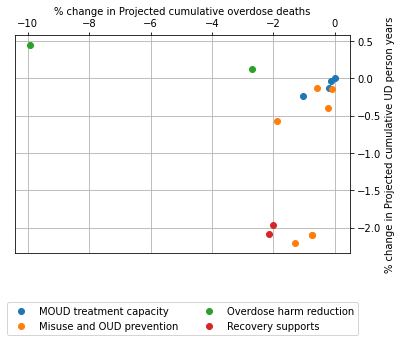

In [127]:
poltot = pd.read_csv(f'X3_Base_poltot.tab', sep='\t', index_col = 0)
poltot = poltot.drop(labels =['Package (Alternate)', 'Package', 'Baseline'] ,axis=0)
# Get category from a row
def get_category(row):
    misuse_OUD_prevention = ['Diverted Rx Init', 'Heroin Init', 'Own Rx Init', 'Diversion', 'People with Rx', 'Rx Duration', 'MME per Rx']
    MOUD = ['XR-NTX Capacity', 'MMT Capacity', 'Bup Prov', 'Bup Prov Barriers']
    HR = ['FentODRisk', 'Nx Kits']
    recovery = ['Return to OUD', 'Peer Recovery']
    baseline = 'Baseline'
    packages = ['Package (Alternate)', 'Package']
    
    if(row.name in misuse_OUD_prevention):
        return 'Misuse and OUD prevention'
    elif(row.name in MOUD):
        return 'MOUD treatment capacity'
    elif(row.name in HR):
        return 'Overdose harm reduction'
    elif(row.name in recovery):
        return 'Recovery supports'
    elif(row.name == baseline):
        return 'Baseline'
    elif(row.name in packages):
        return 'Packages'

poltot["Category"] = poltot.apply(lambda row: get_category(row), axis=1)
grouped_poltot = poltot.groupby("Category")

fig, ax = plt.subplots()

for group, row in grouped_poltot:
    ax.scatter(100*row['% change in Projected cumulative overdose deaths'], 
                100*row['% change in Projected cumulative UD person years'], 
                label=group)
plt.grid()
plt.rcParams['axes.axisbelow'] = True
plt.xlabel('% change in Projected cumulative overdose deaths')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.ylabel('% change in Projected cumulative UD person years')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right') 
plt.legend(loc=8, bbox_to_anchor= (0.5, -0.4), ncol=2)

In [7]:
# def proj_plot_template():
#     """Lay out basic two-axes figure for outcome plots"""
#     fig0, (ax0, ax1) = plt.subplots(1, 2, figsize=[12, 5], constrained_layout=True)
        
#     for ax in [ax0, ax1]:
#         loc = mticker.MultipleLocator(base=2)
#         ax.xaxis.set_major_locator(loc)
#         ax.tick_params(axis='x', labelrotation=90)
#         ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    
#     return fig0, ax0, ax1

# def fmt_proj_template(fig, ax0, ax1):
#     """Format two-axes figure for outcome plots"""
#     ax0.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
#     ax1.yaxis.tick_right()
#     ax1.yaxis.set_label_position('right')
#     ax1.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
#     ax0.set_ylim(-0.27E05, 5.13E05)
#     ax1.set_ylim(-0.2E07, 3.8E07)
#     ax0.set_ylabel('Cumulative overdose deaths (thousands)')
#     ax1.set_ylabel('Cumulative use disorder person-years (millions)')
#     ax0.set_title('Projected cumulative overdose deaths', fontsize=14)
#     ax1.set_title('Projected cumulative use disorder person-years', fontsize=14)
#     ax0.legend(loc=4)

In [ ]:
##### DATA FILE PREPARATION AND CLEANING #####

os.chdir(basedir)
os.makedirs('./Results', exist_ok=True)
os.chdir('./Results')

# Copy over all necessary files from other directories
copy(f'../{baserunname}_fits.tab', './')
copy(f'../{baserunname}_params.tab', './')
for cin in basescens[0:2]:
    copy(f'../Scenarios/{baserunname}_final_{cin[:-4]}.tab', './')
    copy(f'../Scenarios/{baserunname}_sens_{cin[:-4]}_clean.tab', './')
    for proj in proj_subs:
        copy(f'../Scenarios/{baserunname}_final_{cin[:-4]}{proj}.tab', './')
        copy(f'../Scenarios/{baserunname}_sens_{cin[:-4]}{proj}_clean.tab', './')

# Clean & process projection & sensitivity results
for scen in [cin[:-4] for cin in (basescens + scenariolist)]:
    clean_final(baserunname, scen)
    clean_sens(baserunname, scen, fitlist)
    
for scen in [(cin[:-4] + pol[:-4]) for cin in basescens for pol in policylist]:
    clean_final(baserunname, scen)
    clean_sens(baserunname, scen, fitlist)

# copy(f'../Sensitivity/{baserunname}_lk_params.tab', './')
# for key in lkdict.keys():
#     for name in ['lk', 'lk_run']:
#         copy(f'../Sensitivity/{baserunname}_{name}_{key}_{basescens[0][:-4]}.tab', './')
#         clean_final(baserunname, f'{key}_{basescens[0][:-4]}', name=name)

# sensdict = dict([[''.join([w[0] for w in regex.findall(r"[\w']+", var)]), var] for var in sensvars])
# copy(f'../Sensitivity/{baserunname}_assm_params.tab', './')
# for key in sensdict.keys():
#     for sfx in ['_L', '_H']:
#         copy(f'../Sensitivity/{baserunname}_assm_{key}{sfx}_{basescens[0][:-4]}.tab', './')
#         clean_final(baserunname, f'{key}{sfx}_{basescens[0][:-4]}', name='assm')



In [4]:
##### CLEAN THIS UP MORE #####
##### PRODUCE TABLES FOR POLICY PAPER GRAPHS #####

annvars = ['Projected total overdose deaths', 'Projected total with UD']
cumvars = ['Projected cumulative overdose deaths', 'Projected cumulative UD person years']
polstart = 2021
polnames = {"AltPackage": "Package (Alternate)", "BupProv": "Bup Prov", "BupProvBarriers": 
            "Bup Prov Barriers", "Diversion": "Diversion", "DivRxInit": "Diverted Rx Init", 
            "FentODRIsk": "Fent OD Risk", "HInit": "Heroin Init", "MMEperRx": "MME per Rx", 
            "MMTCapInc": "MMT Capacity", "NxKits": "Nx Kits", "OwnRxInit": "Own Rx Init", 
            "Package": "Package", "PeerRecovery": "Peer Recovery", "ReturntoOUD": "Return to OUD", 
            "RxDuration": "Rx Duration", "RxRate": "People with Rx", "XRNTXCap": "XR-NTX Capacity"}

for cin in basescens:
    b = pd.read_csv(f'{baserunname}_final_{cin[:-4]}_vars.tab', sep='\t', index_col=0)
    resdict = {'Baseline': b.loc[annvars]}
    cumdf = pd.DataFrame(columns=cumvars)
    cumdf.loc['Baseline'] = [b.loc[var, str(projyear)] - b.loc[var, str(polstart)] for var in cumvars]
    del b
    
    for pol in policylist:
        scen = cin[:-4] + pol[:-4]
        t = pd.read_csv(f'{baserunname}_final_{scen}_vars.tab', sep='\t', index_col=0)
        resdict[pol[:-4]] = t.loc[annvars]
        cumdf.loc[pol[:-4]] = [t.loc[var, str(projyear)] - t.loc[var, str(polstart)] for var in cumvars]
    
    resdf = pd.concat(resdict, names=['Scenario', 'Var'])
    resdf = resdf.loc[:, str(polstart):]
    resdf = resdf.reorder_levels(['Var', 'Scenario']).sort_index()
        
    chgdict = {}
    for var in annvars:
        chgvar = f'% change in {var}'
        chgdict[chgvar] = (resdf.loc[var] - resdf.loc[(var, 'Baseline')])/resdf.loc[(var, 'Baseline')]
    chgdf = pd.concat(chgdict)
    resdf = resdf.append(chgdf)
        
    for var in cumvars:
        chgvar = f'% change in {var}'
        cumdf[chgvar] = (cumdf[var] - cumdf.loc['Baseline', var])/ cumdf.loc['Baseline', var]
        
    resdf.rename(polnames, inplace=True)
    cumdf.rename(polnames, inplace=True)

    resdf.to_csv(f'{baserunname}_{cin[:-4]}_PolRes.tab', sep='\t')
    cumdf.to_csv(f'{baserunname}_{cin[:-4]}_PolTot.tab', sep='\t')


In [5]:
##### CALCULATE AGGREGATED VARIABLES & STD ERRS #####

fitdict = dict(fitlist)

# Specify aggregate variables to calculate w/ labels
sumlist = [('ROUT', 'ROUD', 'ROUH'), ('InRT', 'InRM', 'InRD'), ('ODRT', 'ODRB', 'ODSB')]
fitdict['ROUT'] = 'Total Rx opioid use disorder'
fitdict['InRT'] = 'Total Rx misuse initiation'
fitdict['ODRT'] = 'Overdose deaths (Rx + Rx synthetics)'

# Calculate aggregates for various results tabfiles
insert_sums(f'{baserunname}_fits.tab', sumlist)
for cin in basescens:
    insert_sums(f'{baserunname}_final_{cin[:-4]}_vars.tab', sumlist, 
                sumvars=['SimVar', 'DataVar', 'RepVar'])
    insert_sums(f'{baserunname}_sens_{cin[:-4]}_clean.tab', sumlist, 
                sumvars=['SimVar', 'RepVar'], index_col=[0,1])

# Read and append standard error terms where available
tssd = pd.read_excel('../../Time series standard deviations.xlsx', 
                     sheet_name='Summary', index_col=[0,1], header=1)

stderrdict = {}
stderrdict['DataErr[InRT]'] = tssd.loc[
    ('Total Rx misuse initiation SAMHSA', 'Standard Error of Weighted Mean')]
stderrdict['DataErr[InHT]'] = tssd.loc[('Total heroin initiation SAMHSA', 'RAND Multiplied SE')]
stderrdict['DataErr[ROUT]'] = (tssd.loc[('Rx OUD no PY heroin NSDUH', 'Standard Error of Weighted Mean')] 
                               + tssd.loc[('Rx OUD + H NSDUH RAND', 'RAND Multiplied SE')])
stderrdict['DataErr[HUD]'] = tssd.loc[('HUD NSDUH RAND', 'RAND Multiplied SE')]

stderrs = pd.concat(stderrdict, axis=1).T
stderrs.columns = stderrs.columns.astype('str')

fits = pd.read_csv(f'{baserunname}_fits.tab', sep='\t', index_col=0)
fits = pd.concat([fits, stderrs])

fits.to_csv(f'{baserunname}_fits.tab', sep='\t')

,MAEN,MAPE,R2,MSE,Um,Us,Uc
Rx misuse,0.070959,0.079538,0.885277,5.452874e+11,0.012937,0.470997,0.516066
Rx OUD no heroin,0.084936,0.094680,0.799540,3.630922e+10,0.004269,0.000809,0.994922
Rx OUD with heroin,0.250659,0.319939,0.715911,2.150504e+09,0.002031,0.193641,0.804328
Nondisordered heroin use,0.237918,0.242927,0.317988,2.433190e+10,0.006388,0.123794,0.869819
Heroin use disorder,0.093268,0.102151,0.899863,2.705653e+10,0.010469,0.000254,0.989276
MOUD Tx (buprenorphine),0.100611,0.481740,0.981131,1.969954e+09,0.216471,0.154388,0.629141
MOUD Tx (methadone),0.014724,0.023829,0.957666,2.198131e+08,0.025101,0.097443,0.877456
MOUD Tx (Vivitrol),0.024151,0.042320,0.999733,8.695079e+04,0.283690,0.371786,0.344523
Rx misuse initiation (own Rx),0.085352,0.095899,0.532842,1.072935e+09,0.005752,0.002207,0.992041
Rx misuse initiation (diverted),0.045846,0.049781,0.937828,9.171066e+09,0.001741,0.000330,0.997929


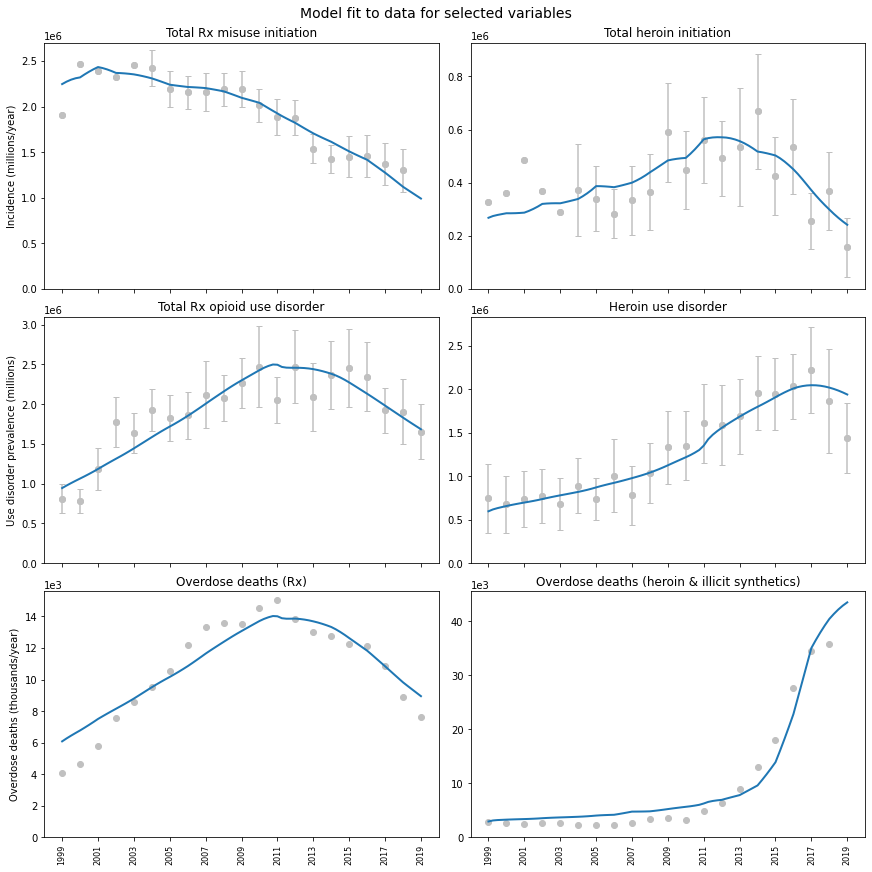

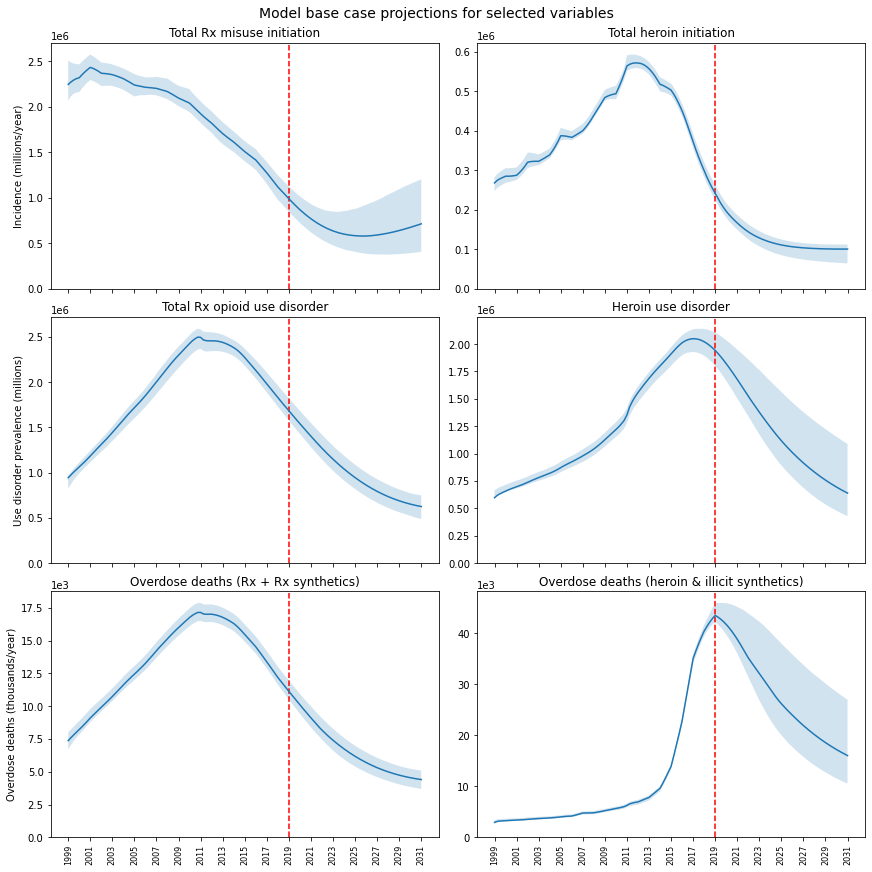

In [22]:
##### PLOT MAIN FITS, PROJECTIONS, GOF STATISTICS #####

# Define y-axis labels for main variable plots
fits_y_labels = ['Incidence (millions/year)', 
                 'Use disorder prevalence (millions)', 
                 'Overdose deaths (thousands/year)']

# Create basic fit-to-data graph for selected variables
fits = pd.read_csv(f'{baserunname}_fits.tab', sep='\t', index_col=0)
# sens = pd.read_csv(f'{baserunname}_sens_Base_clean.tab', sep='\t', index_col=[0,1])
# sens = sens.loc[:, :'2019.0':4]
# sens.columns = sens.columns.astype('float').astype('int').astype('str')
plot_fits_main(fits, mainfits, fitdict, fits_y_labels)

# Create basic projections graph for selected variables
t = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
s = pd.read_csv(f'{baserunname}_sens_{basescens[0][:-4]}_clean.tab', sep='\t', index_col=[0,1])
plot_fits_proj(t, s, projfits, fitdict, bounds, fits_y_labels, endyear=str(endyear))

# Calculate goodness-of-fit statistics
fits = fits[fits.columns[::4]]
gofs = [[*calc_gof(fits, f'SimVar[{elm}]', f'DataVar[{elm}]')] for elm in fitdict.keys()]

gofdf = pd.DataFrame(gofs, index=fitdict.values(), 
                     columns=['MAEN', 'MAPE', 'R2', 'MSE', 'Um', 'Us', 'Uc'])
gofdf.loc['Average'] = gofdf.iloc[0:-3].mean() # Leave out calculated aggregates from average
gofdf.to_csv(f'{baserunname}_GOF.tab', sep='\t')
display(gofdf)


In [42]:
priorlist = [
    ["NFRR", "2013", "Nonfatal OD ratio Rx"], ["NFRH", "2013", "Nonfatal OD ratio heroin"], 
    ["DFRB", "2018", "Bup demand fulfilment ratio"], ["PNxH", "2019", "Probability Nx bystander heroin"], 
    ["NxHF", "2013", "Nx utilization events H user fraction"], ["RemO", "2013", "Rx OUD in remission total"], 
    ["RemH", "2013", "HUD in remission total"]
]




In [48]:
##### COMPILE AND EXPORT INPUT AND SELECTED YEAR-BY-YEAR VALUES #####

# Assemble input time series projection values
table = pd.read_csv(f'{baserunname}_final_Base_vars.tab', sep='\t', index_col=0)

inputslist = ['Input\t2019\t2031\n']
for proj in proj_subs:
    val2019 = table.loc[f'Projection output data[{proj}]', '2019']
    val2031 = table.loc[f'Projection output data[{proj}]', '2031']
    inputslist.append(f'{proj}\t{val2019}\t{val2031}\n')
    
with open(f'{baserunname}_inputs.tab', 'w') as f:
    f.writelines(inputslist)
del table

# Compile yearvals output for specified variables and years from sensitivity projections
t = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
s = pd.read_csv(f'{baserunname}_sens_{basescens[0][:-4]}_clean.tab', sep='\t', index_col=[0,1])

vartext = [f'Year\tVal\t{yv_percs[0]}\t{yv_percs[1]}\n']
for var in yearvals:
    vartext.extend(get_year_values(t, s, var, years, yv_percs, var))

# Get projection end values
for var in projvars:
    vartext.extend(get_year_values(t, s, var, [str(projyear)], yv_percs, var))
    
# Add prior values
for prior in priorlist:
    vartext.extend(get_year_values(t, s, f'SimPrior[{prior[0]}]', [prior[1]], yv_percs, prior[2], var))

with open(f'{baserunname}_yearvals.tab', 'w') as f:
    f.writelines(vartext)

In [24]:
##### ALTERNATIVE PROJECTION ASSUMPTIONS SENSITIVITY ANALYSIS #####

dflist = []

# Iterate through comparisons to each basescen
for cin in basescens[0:2]:
    first = f'{baserunname}_sens_{cin[:-4]}_clean.tab'

    vals_chgs = []
    for proj in proj_subs:
        second = f'{baserunname}_sens_{cin[:-4]}{proj}_clean.tab'
        vals_chgs.append(compare_vals(first, second, projvars, projyear))
    dflist.append(pd.DataFrame(vals_chgs, index=proj_subs, columns=projvars))

avgchgdf = (dflist[0] - dflist[1]) / 2 # NOTE: expressed as delta from 'base' to 'cnst'
dflist.append(avgchgdf)

# Assemble and export comparison results
cols = [f'{cin} {var}' for cin in ['Base', 'Cnst', 'Avg'] for var in projvars]
chgsdf = pd.concat(dflist, axis=1)
chgsdf.loc['MAC'] = abs(chgsdf).mean()
chgsdf.columns = cols
chgsdf.to_csv(f'{baserunname}_proj_changes.tab', sep='\t')


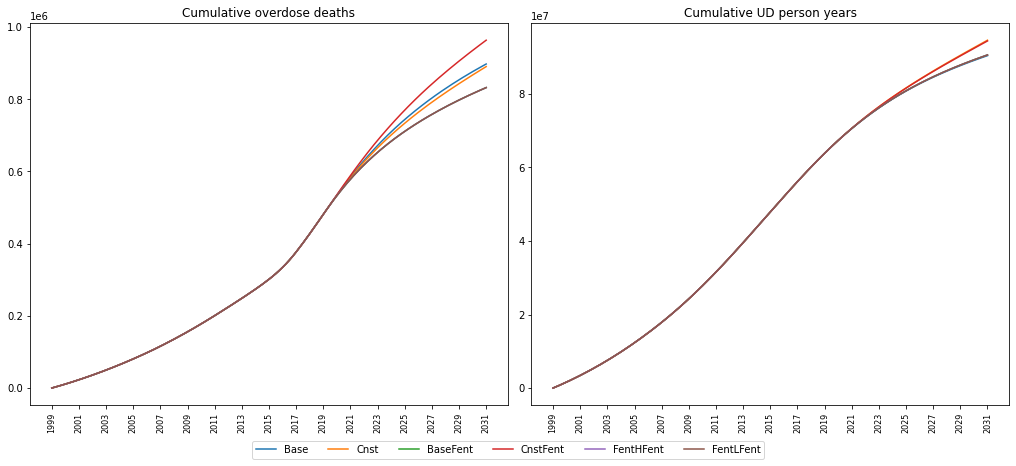

In [39]:
### UPDATE & CLEAN THIS
##### ALTERNATIVE PROJECTION ASSUMPTIONS SENSITIVITY GRAPHS #####

proj_plots = ['Fent']
outvars = ['Cumulative overdose deaths', 'Cumulative UD person years']
proj_scens = [f'{cin[:-4]}{proj}' for cin in basescens for proj in proj_plots]

# Read in and clean sensitivity projection results
for scen in proj_scens:
    clean_final(baserunname, scen)

fig0, (ax0, ax1) = plt.subplots(1, 2, figsize=[14, 6], constrained_layout=True)
proj_scens = [scen[:-4] for scen in basescens[0:2]] + proj_scens

for ax, var in zip([ax0, ax1], outvars):
    lines = []
    
    for scen in proj_scens:
        t = pd.read_csv(f'{baserunname}_final_{scen}_vars.tab', sep='\t', index_col=0)
#         s = pd.read_csv(f'{baserunname}_sens_{scen}_clean.tab', sep='\t', index_col=[0,1])
    
        line = ax.plot(t.columns, t.loc[var], label=scen)
        lines.extend(line)
#         for bd in bounds:
#             ax.fill_between(t.columns, s.loc[var, bd[0]], s.loc[var, bd[1]], alpha=0.2)  
    
    ax.set_title(var)

    loc = mticker.MultipleLocator(base=8)
    ax.xaxis.set_major_locator(loc)
    ax.tick_params(axis='x', labelsize=8, labelrotation=90)    

labels = [line.get_label() for line in lines]
fig0.legend(lines, labels, loc=9, bbox_to_anchor=(0.5, 0), ncol=6)

fig0.savefig(f"./{baserunname}_alt_projs.jpg", bbox_inches='tight')

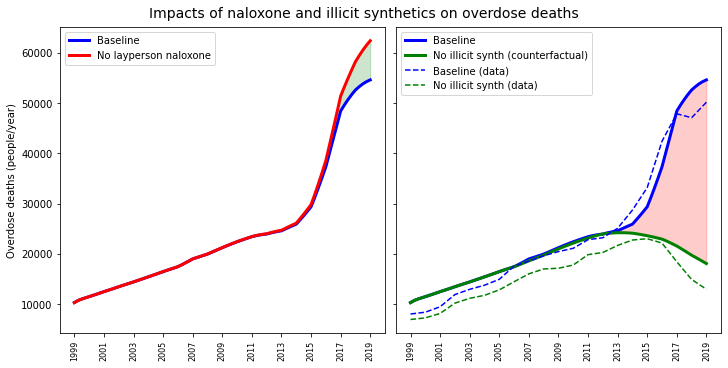

In [28]:
##### PLOT FENTANYL AND NALOXONE COUNTERFACTUALS GRAPHS #####

# Read in base and no-fentanyl scenario results
table = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
nft = pd.read_csv(f'{baserunname}_final_{scenariolist[0][:-4]}_vars.tab', sep='\t', index_col=0)
table = table.loc[:, :f'{endyear}'] # Truncate results to just historical portion
nft = nft.loc[:, :f'{endyear}']

# Compile separate dataframe of just relevant results
baseod = table.loc['Total overdose deaths']
nxodav = (table.loc['Nx utilization deaths averted Rx user'] 
          + table.loc['Nx utilization deaths averted H user'])
nofent = nft.loc['Total overdose deaths']
nfdata = (table.loc['Total overdose deaths base Rx NVSS'] 
          + table.loc['Total overdose deaths base heroin NVSS'])
nfnxav = (nft.loc['Nx utilization deaths averted Rx user'] 
          + nft.loc['Nx utilization deaths averted H user'])
oddata = table.loc['Total overdose deaths NVSS']

del table, nft # Clear large dataframes once unneeded to free up memory 

odcomp = pd.concat([baseod, nxodav, nofent, nfdata, nfnxav, oddata], 
                   keys=['Base', 'NxDA', 'NoFent', 'NFData', 'NFNxDA', 'ODData'], axis=1)

# Calculate sums to stack graphs
odcomp['NoNx'] = odcomp['Base'] + odcomp['NxDA']
odcomp['NFNoNx'] = odcomp['NoFent'] + odcomp['NFNxDA']
# Interpolate data to allow complete line plotting
odcomp['NFData'] = odcomp['NFData'].interpolate()
odcomp['ODData'] = odcomp['ODData'].interpolate()

# Set up two-axes figure
fig0, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 5], sharey=True, constrained_layout=True)

# Plot naloxone results on first axes
base = ax0.plot(odcomp['Base'], color='b', lw=3, label='Baseline')
nonx = ax0.plot(odcomp['NoNx'], color='r', lw=3, label='No layperson naloxone')
ax0.fill_between(odcomp.index, odcomp['Base'], odcomp['NoNx'], color='g', alpha=0.2)
ax0.legend()

# Plot fentanyl results and data on second axes
base2 = ax1.plot(odcomp['Base'], color='b', lw=3, label='Baseline')
nfnt = ax1.plot(odcomp['NoFent'], color='g', lw=3, label='No illicit synth (counterfactual)')
ax1.fill_between(odcomp.index, odcomp['Base'], odcomp['NoFent'], color='r', alpha=0.2)
based = ax1.plot(odcomp['ODData'], ls='dashed', color='b', label='Baseline (data)')
nfntd = ax1.plot(odcomp['NFData'], ls='dashed', color='g', label='No illicit synth (data)')
ax1.legend()

loc = mticker.MultipleLocator(base=8)
for ax in [ax0, ax1]:
    ax.xaxis.set_major_locator(loc)
    ax.tick_params(axis='x', labelsize=8, labelrotation=90)
    
# Set labels for left-hand axes only, and figure title
ax0.set_ylabel('Overdose deaths (people/year)')
fig0.suptitle('Impacts of naloxone and illicit synthetics on overdose deaths', fontsize=14)

fig0.savefig(f"./{baserunname}_fentnxod.jpg", bbox_inches='tight')

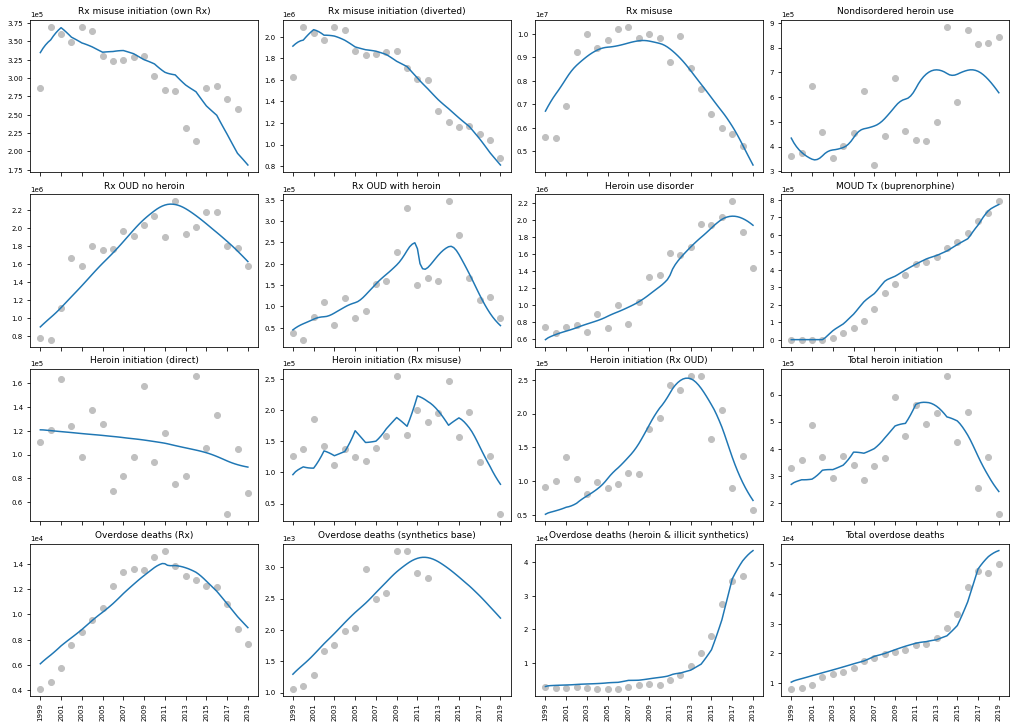

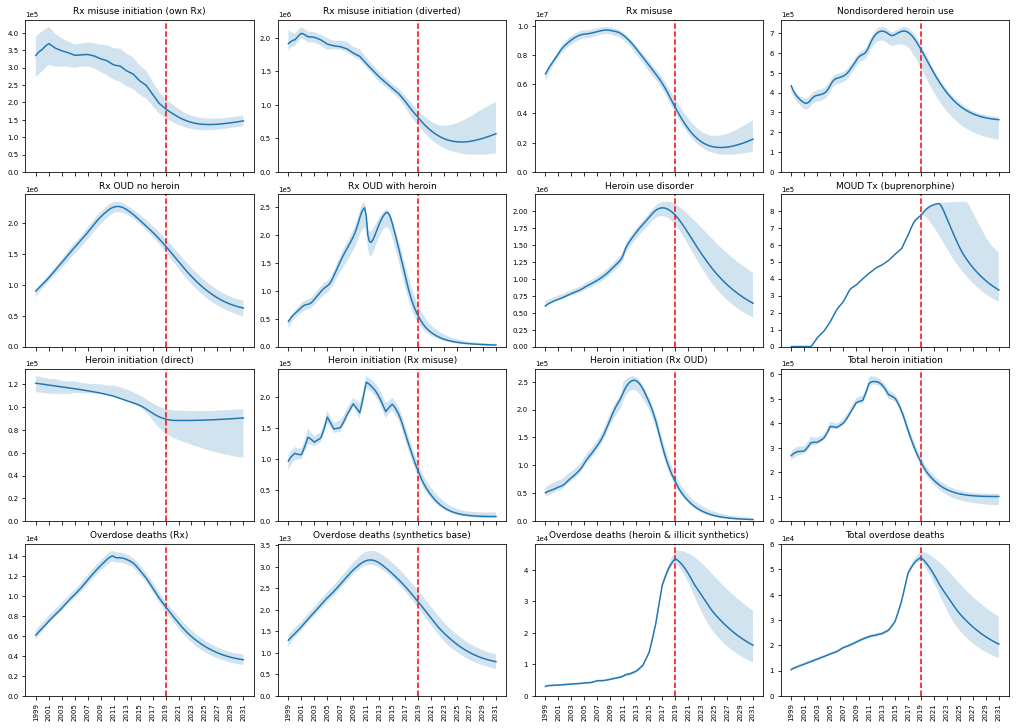

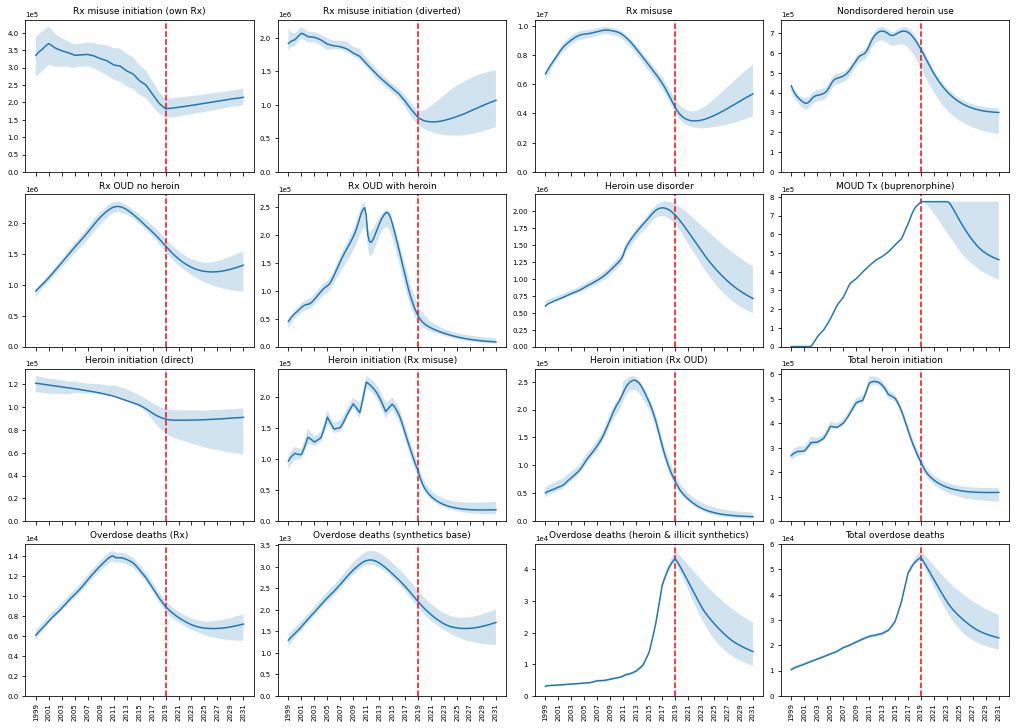

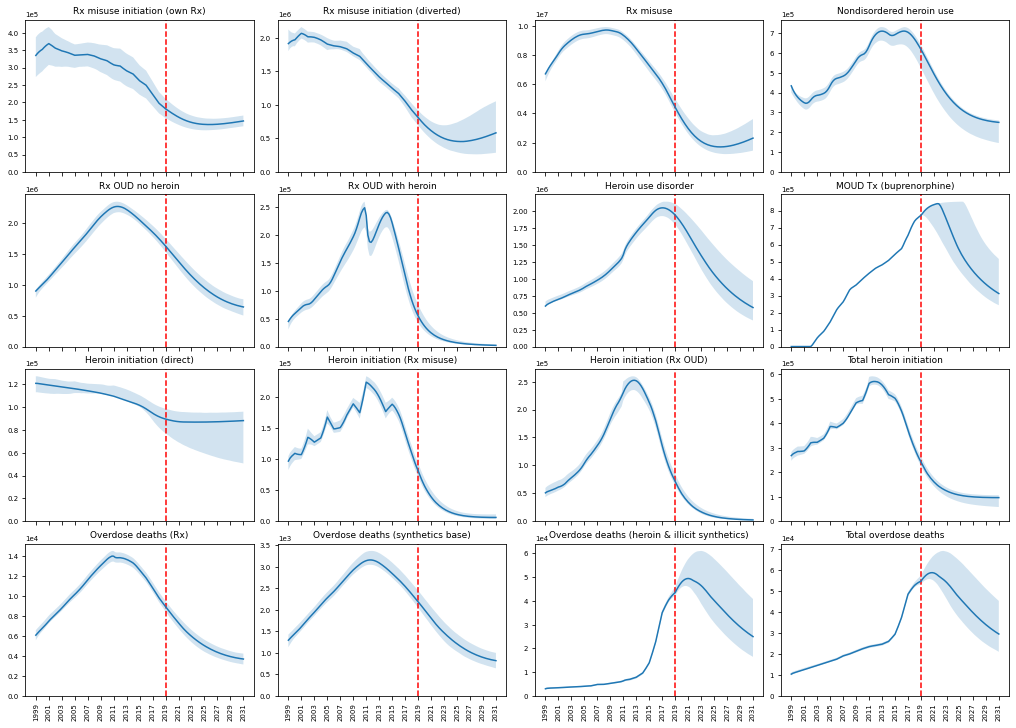

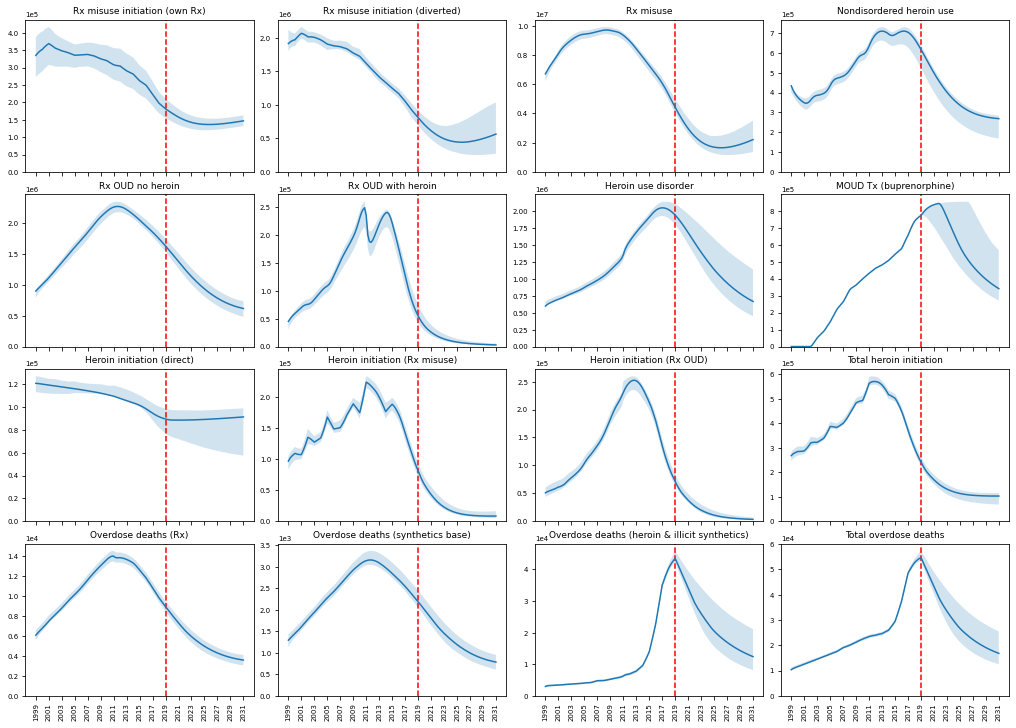

In [29]:
##### PLOT ALL VARS FIT TO DATA & PROJECTIONS #####

# Specify all vars to be included
fullfits = ['InRM', 'InRD', 'RMis', 'NDHU', 'ROUD', 'ROUH', 'HUD', 'TxBp', 
            'InHD', 'InHR', 'InHO', 'InHT', 'ODRB', 'ODSB', 'ODHC', 'ODTo']

# Read in and plot fits to data
table = pd.read_csv(f'{baserunname}_fits.tab', sep='\t', index_col=0)
fig0 = plot_fits_full(table, fullfits, fitdict)
fig0.savefig(f"./{baserunname}_fits_full.jpg", bbox_inches='tight')

# Read in main and sensitivity results to plot all vars projections for each base scenario
for scen in basescens:
    t = pd.read_csv(f'{baserunname}_final_{scen[:-4]}_vars.tab', sep='\t', index_col=0)
    s = pd.read_csv(f'{baserunname}_sens_{scen[:-4]}_clean.tab', sep='\t', index_col=[0,1])
#     t.columns = t.columns.astype('float').astype('int').astype('str')
#     s.columns = s.columns.astype('float').astype('int').astype('str')

    fig1 = plot_fits_proj_full(t, s, fullfits, fitdict, bounds, endyear=str(endyear))
    fig1.savefig(f"./{baserunname}_fits_proj_full_{scen[:-4]}.jpg", bbox_inches='tight')


Perc
50           0.363699
80           0.626027
90           0.721918
95           0.781507
98           0.818493
dist95       0.486049
Dist95Med    0.303947
dtype: float64

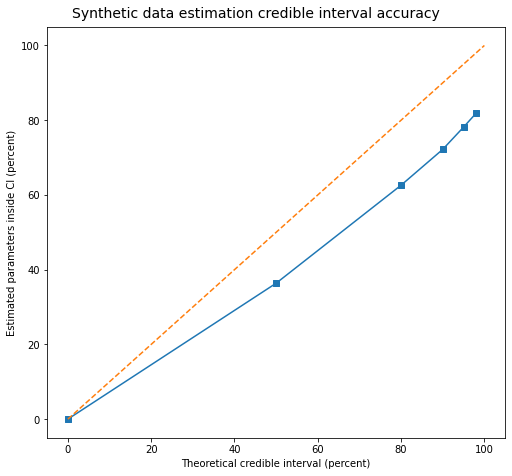

In [30]:
##### SYNDATA CI PROCESSING & GRAPHS #####

# Specify CIs to track & graph and main percent CI
percs = [50, 80, 90, 95, 98]

# Read in data
syndf = pd.read_csv(f'{baserunname}_syndata_results.tab', sep='\t', index_col=[0, 1])
syndf = syndf.reorder_levels(['Perc', 'Run']).sort_index()

spdfdict = {}

# Create Boolean df tracking which values are within which percent CIs
for perc in percs:
    bds = strbds_from_perc(perc) # Calculate CI bounds for each percent CI
    spdfdict[perc] = ((syndf.loc['True'] > syndf.loc[bds[0]]) 
                      & (syndf.loc['True'] < syndf.loc[bds[1]]))

# Calculate distance of estimate from median relative to main CI
bdsmain = strbds_from_perc(95)
spdfdict[f'dist{syn_mainperc}'] = abs((syndf.loc['Value'] - syndf.loc['True']) / 
                                      (syndf.loc[bdsmain[1]] - syndf.loc[bdsmain[0]]))

# Compile and export percent CI calculations
synpercdf = pd.concat(spdfdict, names=['Perc', 'Run'])
synpercdf.to_csv(f'{baserunname}_syndata_intervals.tab', sep='\t')

# Collapse Boolean df to get mean percentages within each CI
means = synpercdf.mean(axis=1).groupby('Perc').mean()
means[f'Dist{syn_mainperc}Med'] = np.nanmedian(spdfdict[f'dist{syn_mainperc}'])
means.to_csv(f'{baserunname}_syndata_means.tab', sep='\t')

# Plot theoretical CI vs. actual included values comparison
fig0 = plot_syndata_intervals(means, percs)
fig0.savefig(f"./{baserunname}_syn_intervals.jpg", bbox_inches='tight')
means

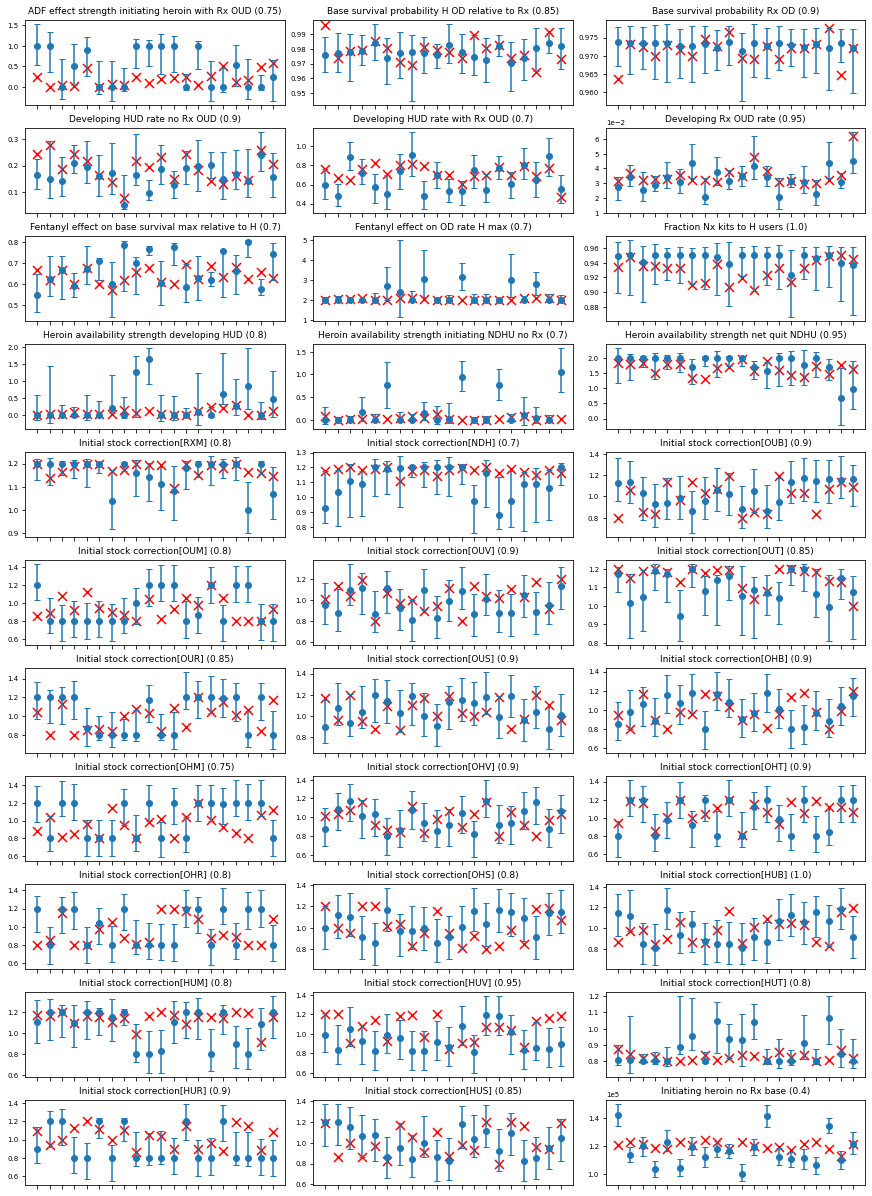

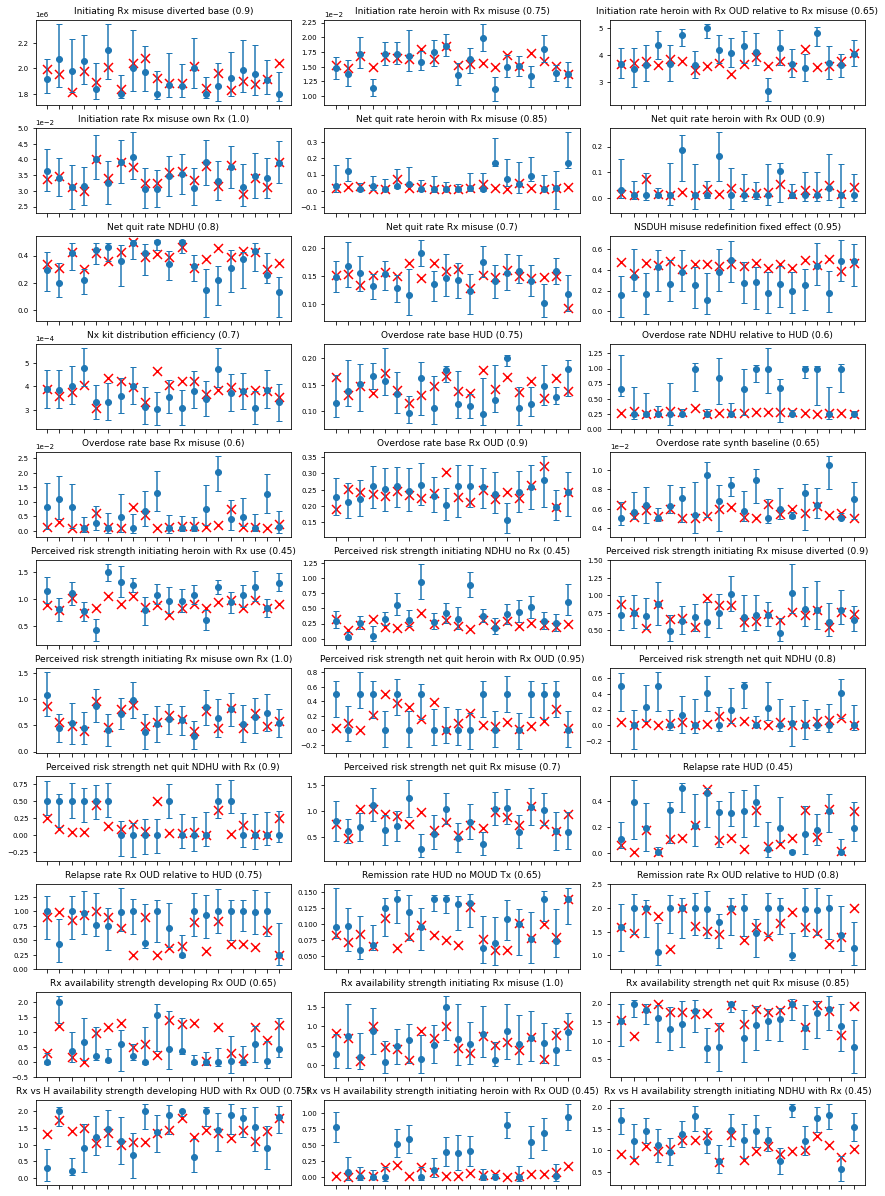

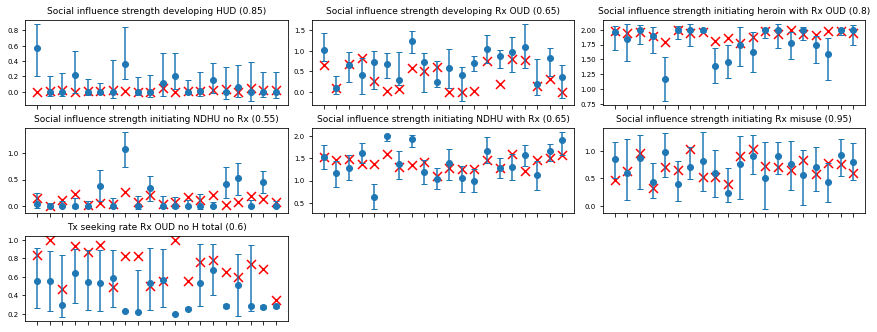

In [31]:
##### SYNDATA PARAM ESTIMATES MEGA-PLOT #####

# Plot syndata param estimates and true values, breaking up mega-plot to fit on separate pages
fig0 = plot_syndata_params(syndf.iloc[:, 0:33], synpercdf.iloc[:, 0:33], syn_mainperc)
fig0.savefig(f'./{baserunname}_syn_params_0.jpg', bbox_inches='tight')
fig1 = plot_syndata_params(syndf.iloc[:, 33:66], synpercdf.iloc[:, 33:66], syn_mainperc)
fig1.savefig(f'./{baserunname}_syn_params_1.jpg', bbox_inches='tight')
fig2 = plot_syndata_params(syndf.iloc[:, 66:], synpercdf.iloc[:, 66:], syn_mainperc)
fig2.savefig(f'./{baserunname}_syn_params_2.jpg', bbox_inches='tight')

In [32]:
##### CALCULATE VALUES FOR SUMMARYTEXT #####

# Pull values for fentanyl counterfactual ODs
table = pd.read_csv(f'{baserunname}_final_{scenariolist[0][:-4]}_vars.tab', sep='\t', index_col=0)
nofentods = table.loc['Cumulative overdose deaths', '2019']
nofentodsdata = np.sum((odcomp['ODData'] - odcomp['NFData'])[::4])
del table

# Calculate MCMC sample size
mcsample = mcsettings['MCLIMIT'] - mcsettings['MCBURNIN']

# Calculate PSRF percentages below 1.1 and 1.2 key thresholds
mcout = pd.read_csv(f'{baserunname}_main_MC_MCMC_stats.tab', sep='\t', index_col=0)
psrfs = [i for i in mcout.index if 'PSRF' in i]
psrfs.remove('PSRF Payoff')
mcout = mcout.loc[psrfs]
mcout.columns = mcout.columns.astype('float').astype('int')
mcout = mcout[mcout.columns[mcout.columns > mcsettings['MCBURNIN']]]
psrf12 = np.nanmean(mcout < 1.2)
psrf11 = np.nanmean(mcout < 1.1)
del mcout

# Get parameter numbers
t = pd.read_csv(f'{baserunname}_params.tab', sep='\t', index_col=0)
iscs = len([idx for idx in t.index if 'Initial stock correction' in idx])
estpars = len(t.index) - iscs
del t

# Compile summarytext
summarytext = [
    f"Exogenous inputs\t{len(proj_subs)}\n", 
    f"Calibration time series\t{len(fitlist) - 3}\n", 
    f"MCMC total\t{mcsettings['MCLIMIT']}\n", 
    f"MCMC burnin\t{mcsettings['MCBURNIN']}\n", 
    f"MCMC sample\t{mcsample}\n", 
    f"MCMC PSRF < 1.2\t{psrf12}\t< 1.1\t{psrf11}\n", 
    f"Sensitivity sample\t{int(mcsample * samplefrac)}\n", 
    f"Sensitivity analysis range\t{sensrange}\n", 
    f"Syndata sets\t{synsample}\n", 
    f"Estimated parameters (no ISCs)\t{estpars}\n", 
    f"Initial stock corrections\t{iscs}\n", 
    f"Cumulative OD deaths without fentanyl\t{int(nofentods)}\n", 
    f"Cumulative synth-involved OD deaths DATA\t{int(nofentodsdata)}\n", 
    f"Confidence interval estimated params\t{round(param_percs[-1] - param_percs[0], 3)}\n", 
    f"Confidence interval estimated params\t{syn_mainperc/100}\n"
]

# Calculate projection differences for key outcomes expressed as delta from 'base' to 'cnst'
first = f'{baserunname}_sens_{basescens[0][:-4]}_clean.tab'
second = f'{baserunname}_sens_{basescens[1][:-4]}_clean.tab'
basecomps = compare_vals(first, second, projvars, projyear)

summarytext.extend([f"Base-Cnst delta for {var}\t{val}\n" for var, val in zip(projvars, basecomps)])

# Read fixed parameter values from .mdl file
mdl = f"../{simsettings['model']}"
summarytext.append("\n\nFixed parameter values\n")
summarytext.extend([f'{var}\t{get_value(mdl, var)}\n' for var in paramvals])

# Create relative Tx-seeking rate table
ot = 1
ob = get_value(mdl, "Tx seeking fraction Bup Rx OUD")
om = round((ot - ob) * get_value(mdl, "Tx seeking fraction MMT Rx OUD relative"), 5)
ov = round(ot - ob - om, 5)
ht = get_value(mdl, "Tx seeking rate HUD relative to Rx OUD no H")
hb = round(ht * get_value(mdl, "Tx seeking fraction Bup HUD"), 5)
hm = round((ht - hb) * get_value(mdl, "Tx seeking fraction MMT HUD relative"), 5)
hv = round(ht - hb - hm, 5)

summarytext.extend(["\n\n", "Relative Tx seeking rates\n", 
                    f"OUD\t{ot}\t{ob}\t{om}\t{ov}\n", f"HUD\t{ht}\t{hb}\t{hm}\t{hv}\n"])

# Export summary text file
with open(f"{baserunname}_summary.txt", 'w') as summaryfile:
    summaryfile.writelines(summarytext)

display(summarytext)


['Exogenous inputs\t10\n',
 'Calibration time series\t15\n',
 'MCMC total\t2500000\n',
 'MCMC burnin\t1500000\n',
 'MCMC sample\t1000000\n',
 'MCMC PSRF < 1.2\t0.9688667496886675\t< 1.1\t0.9153175591531756\n',
 'Sensitivity sample\t5000\n',
 'Sensitivity analysis range\t0.1\n',
 'Syndata sets\t20\n',
 'Estimated parameters (no ISCs)\t53\n',
 'Initial stock corrections\t20\n',
 'Cumulative OD deaths without fentanyl\t380520\n',
 'Cumulative synth-involved OD deaths DATA\t170563\n',
 'Confidence interval estimated params\t0.9\n',
 'Confidence interval estimated params\t0.95\n',
 'Base-Cnst delta for Projected cumulative overdose deaths\t-0.01709016803588162\n',
 'Base-Cnst delta for Projected cumulative UD person years\t0.14056920984544277\n',
 '\n\nFixed parameter values\n',
 'Perceived risk weight NFOD\t0.1\n',
 'Average prescription duration\t0.059\n',
 'OxyContin withdrawal magnitude\t0.45\n',
 'Tx seeking rate HUD relative to Rx OUD no H\t4.843\n',
 'Bup effective capacity decay con

,Cumulative overdose deaths,Cumulative UD person years,Projected cumulative overdose deaths,Projected cumulative UD person years,Med elasticity,Max elasticity,Avg MAEN,Max MAEN
Deactivated Availability,-0.334834,-0.267421,-0.446106,-0.242952,0.000000,0.000000,0.290051,0.619021
Recalibrated w/o Availability,-0.000603,-0.004518,0.123777,0.172153,0.074623,31.152836,0.139975,0.317645
Deactivated Perceived risk,1.546942,0.647989,5.279160,2.133076,0.000000,0.000000,1.674355,8.214936
Recalibrated w/o Perceived risk,-0.006066,0.005514,0.186151,0.027390,0.150032,24.000000,0.154745,0.273102
Deactivated Social influence,-0.171987,-0.109585,-0.193599,-0.045039,0.000000,0.000000,0.219523,0.508640
Recalibrated w/o Social influence,-0.002185,0.004430,0.258363,0.048742,0.062732,3.458392,0.135704,0.293796


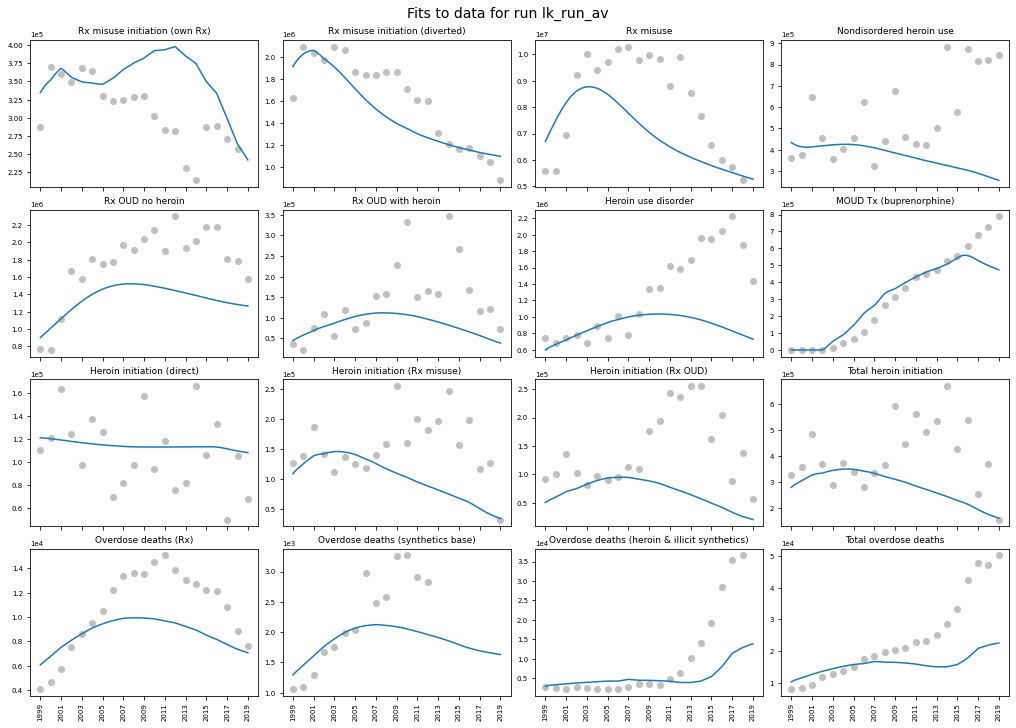

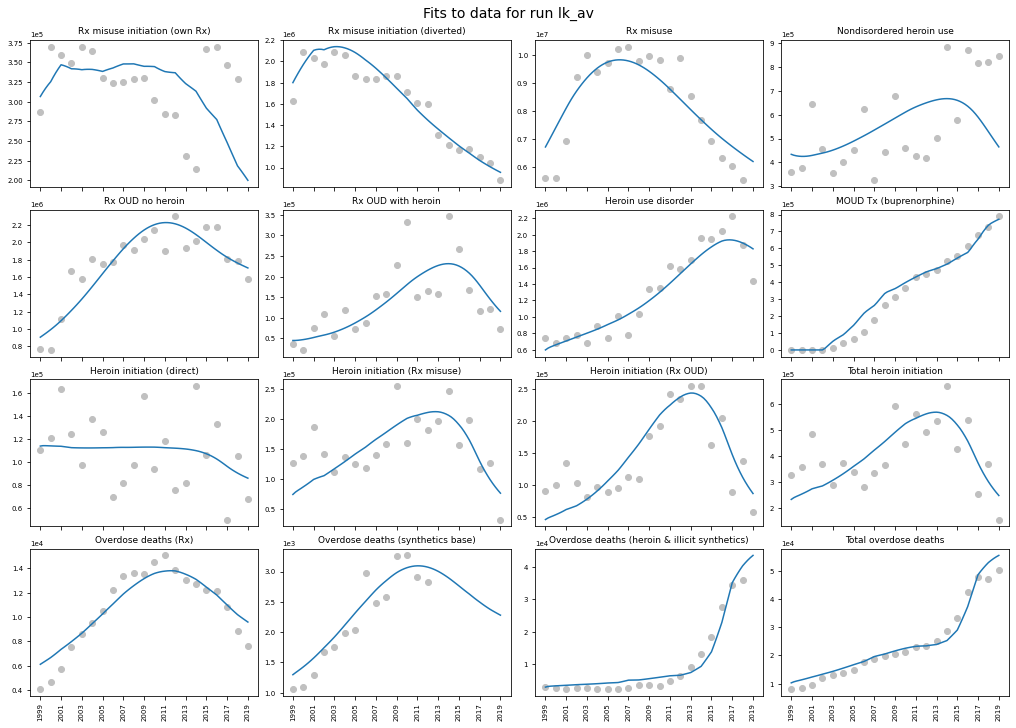

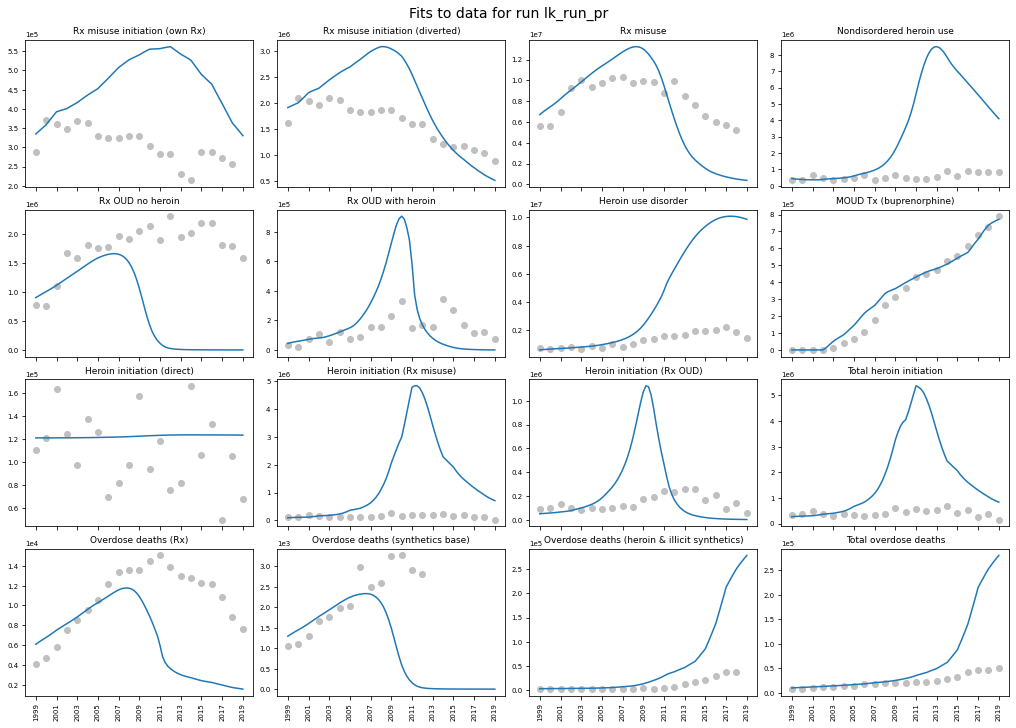

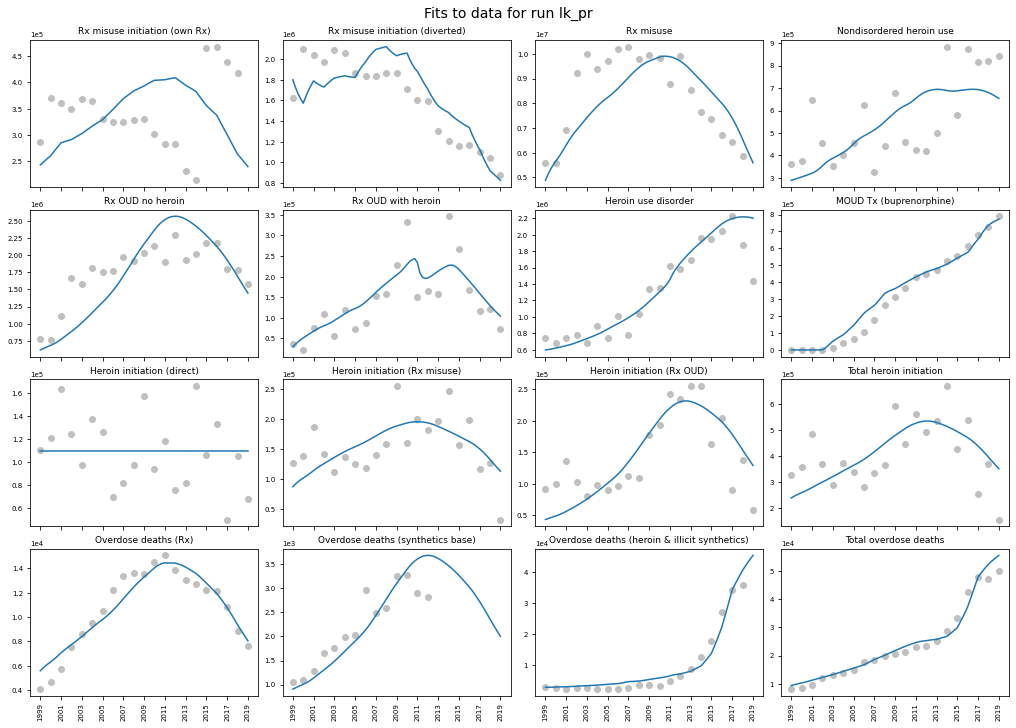

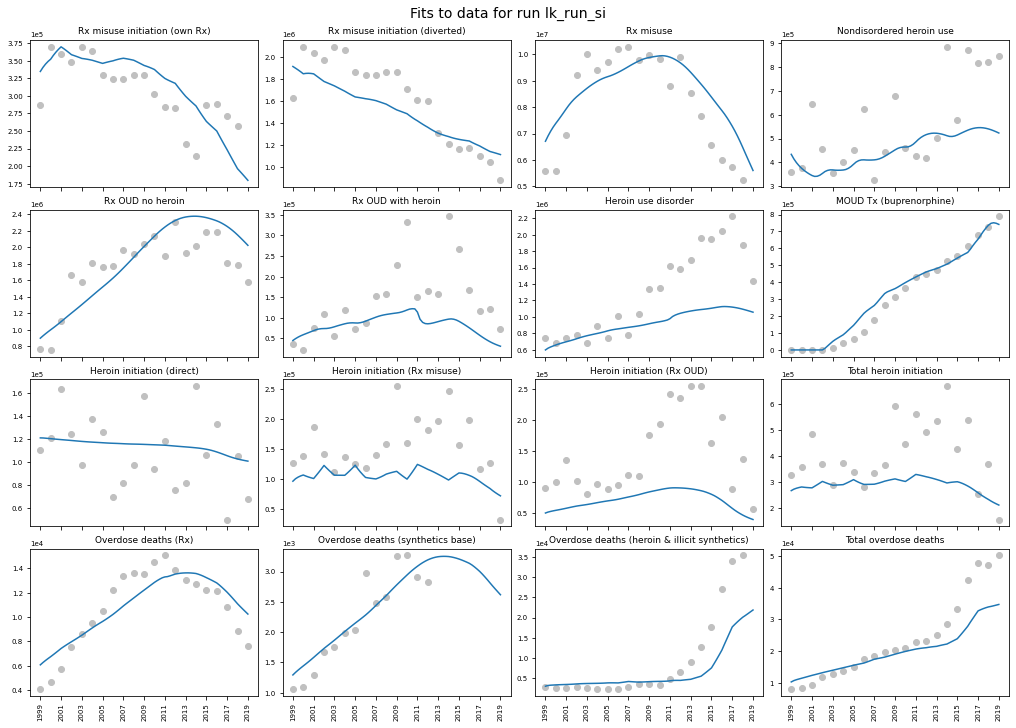

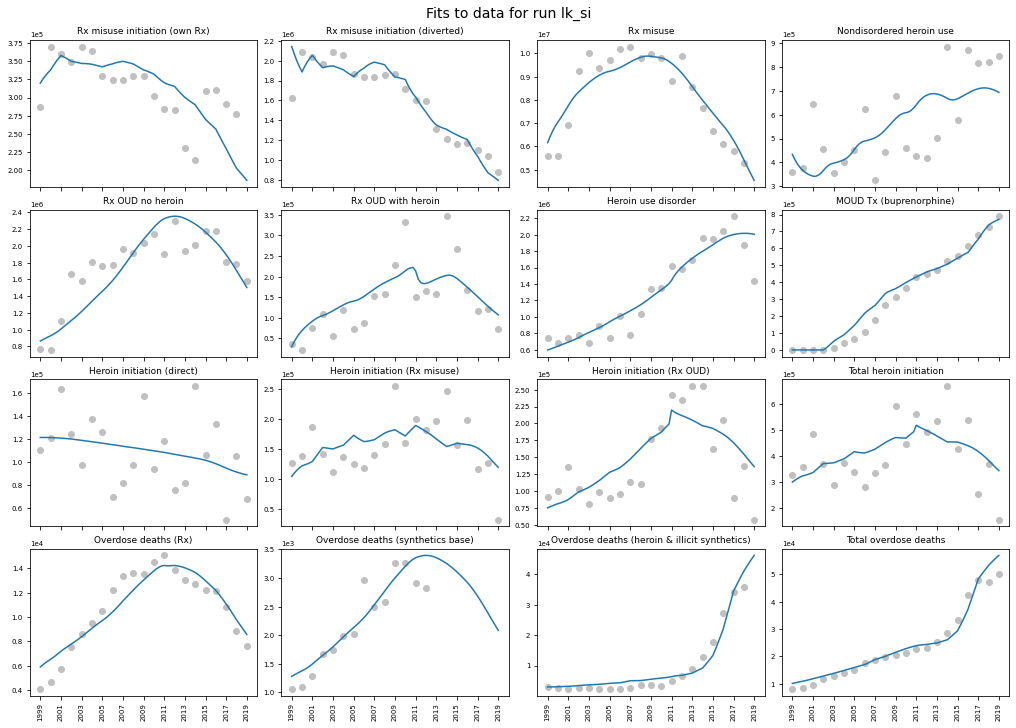

In [35]:
##### LOOP KNOCKOUT ANALYSIS PANEL #####

# Set up labels for loop knockout keys
lknamedict = {'av': 'Availability', 'pr': 'Perceived risk', 'si': 'Social influence'}

lkdfdict = {}

# Iterate through loop knockout keys and compile deactivated and re-estimated results from each
for key in lkdict.keys():
    lkdfdict['Deactivated ' + lknamedict[key]] = compile_sens_panel(
        baserunname, 'lk_run', key, basescens[0][:-4], outvars, projvars, 
        str(endyear), str(projyear), dropvars=lkdict[key], params=False, plot=True)
    lkdfdict['Recalibrated w/o ' + lknamedict[key]] = compile_sens_panel(
        baserunname, 'lk', key, basescens[0][:-4], outvars, projvars, 
        str(endyear), str(projyear), dropvars=lkdict[key], plot=True)

# Compile and export results
lkdf = pd.concat(lkdfdict, axis=1).T
lkdf.to_csv(f'{baserunname}_lk_sens.tab', sep='\t')
lkdf

In [36]:
##### PARAMETRIC ASSUMPTIONS SENSITIVITY ANALYSIS PANEL #####

# Compile runnames from variable names in sensvars
sensdict = dict([[''.join([w[0] for w in regex.findall(r"[\w']+", var)]), var] for var in sensvars])

assmdfdict = {} # Initiatlise container for results

# Iterate through sensvars names and compile results from each
for key in sensdict.keys():
    # Compile high and low scenario results panels
    high = compile_sens_panel(baserunname, 'assm', f'{key}_L', basescens[0][:-4], outvars, 
                              projvars, str(endyear), str(projyear))
    low = compile_sens_panel(baserunname, 'assm', f'{key}_H', basescens[0][:-4], outvars, 
                             projvars, str(endyear), str(projyear))
    
    # Concatenate and take average
    var = pd.concat({'H': high, 'L': low}, axis=1)
    var['avg'] = (abs(var['H']) + abs(var['L'])) / 2 * np.sign(var['H']) # Take sign from H change
    var['avg'].iloc[0:6] = var['avg'].iloc[0:6] / sensrange # Convert to elasticity
    assmdfdict[sensdict[key]] = var['avg']

# Compile and export results
assmdf = pd.concat(assmdfdict, axis=1).T
assmdf.to_csv(f'{baserunname}_assm_sens.tab', sep='\t')
assmdf


,Cumulative overdose deaths,Cumulative UD person years,Projected cumulative overdose deaths,Projected cumulative UD person years,Med elasticity,Max elasticity,Avg MAEN,Max MAEN
ADF substitutability factor,-0.003014,0.009670,-0.043025,-0.102152,0.012859,3.924587,0.126123,0.250880
Average prescription duration,-0.002775,0.007407,-0.189916,-0.158667,0.051308,9.506114,0.126074,0.250794
Effect of MOUD Tx on OD death rate[Bup],-0.001840,0.013100,0.204298,-0.128311,0.051943,10.014755,0.126084,0.250763
Effect of MOUD Tx on OD death rate[MMT],-0.003232,0.005489,-0.057827,-0.117434,0.013594,4.589808,0.126146,0.251006
Effect of MOUD Tx on OD death rate[Viv],-0.003679,0.005974,-0.143481,-0.182813,0.011037,4.336846,0.126162,0.251083
OxyContin withdrawal magnitude,-0.002921,0.004917,-0.075282,-0.093269,0.021045,-3.414796,0.126147,0.251125
Perceived risk decrease time,-0.002224,0.008770,-0.018151,-0.080209,0.017710,7.719002,0.126155,0.250954
Perceived risk increase time,-0.002339,0.009561,-0.048944,-0.120878,0.015733,4.103287,0.126162,0.250983
Perceived risk weight NFOD,0.002401,0.010093,0.150408,0.157594,0.035760,5.069961,0.126073,0.250785
Probability OD witnessed,0.004095,0.012834,0.121417,-0.040462,0.027306,-6.295112,0.126134,0.250960


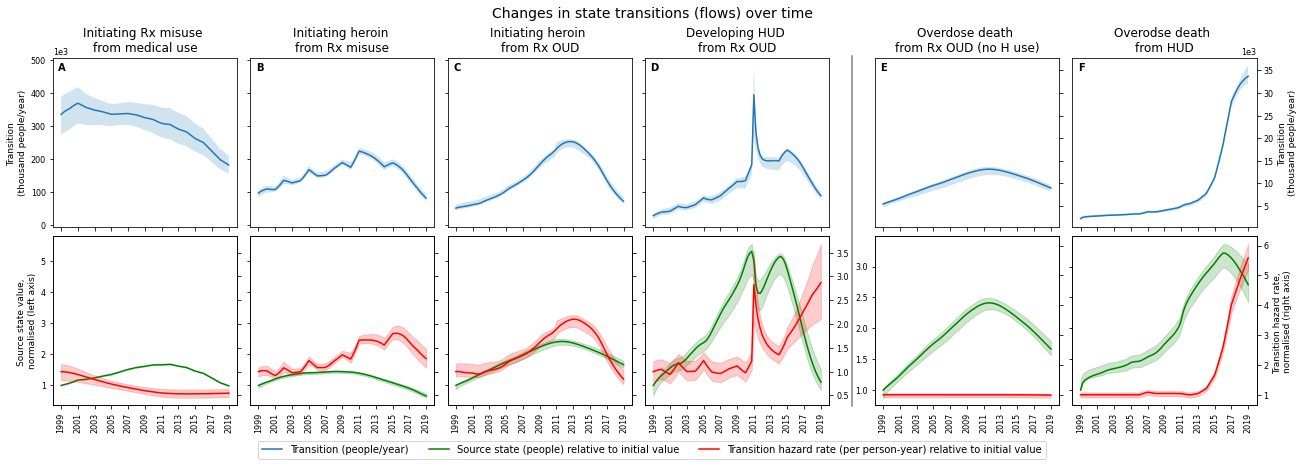

In [37]:
##### RATE-STOCK-HAZARD PLOT #####

# Read in main and sensitivity results
t = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
t = t.loc[:, :f'{endyear}']
s = pd.read_csv(f'{baserunname}_sens_{basescens[0][:-4]}_clean.tab', sep='\t', index_col=[0,1])
s = s.loc[:, :f'{float(endyear)}']

# Establish list of rates-stocks-hazards-titles
rateslist = [
    ['Initiating Rx misuse own Rx', 'Patients with current opioid Rx', 
     'Initiation rate Rx misuse own Rx effective', 'Initiating Rx misuse \nfrom medical use'], 
    ['Initiating heroin with Rx misuse', 'Rx misuse no PY heroin', 
     'Initiation rate heroin with Rx misuse effective', 'Initiating heroin \nfrom Rx misuse'], 
    ['Initiating heroin with Rx OUD', 'Rx OUD no PY heroin no MOUD', 
     'Initiation rate heroin with Rx OUD effective', 'Initiating heroin \nfrom Rx OUD'], 
    ['Developing HUD with Rx OUD', 'Rx OUD with PY heroin no MOUD', 
     'Developing HUD rate with Rx OUD effective', 'Developing HUD \nfrom Rx OUD'], 
    ['Overdose death Rx OUD no H', 'Rx OUD no PY heroin no MOUD', 
     'Overdose death rate Rx OUD no H', 'Overdose death \nfrom Rx OUD (no H use)'], 
    ['Overdose death HUD', 'HUD no MOUD', 
     'Overdose death rate HUD', 'Overodse death \nfrom HUD']
]

# Set up main figure with axes and twinned lower axes
fig0, ((ax0, ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10, ax11)) = plt.subplots(
    2, 6, figsize=[18, 6], sharex=True, constrained_layout=True)

row0 = [ax0, ax1, ax2, ax3, ax4, ax5]
row1a = [ax6, ax7, ax8, ax9, ax10, ax11]

ax12, ax13, ax14, ax15, ax16, ax17 = [ax.twinx() for ax in row1a]
row1b = [ax12, ax13, ax14, ax15, ax16, ax17]

ax_list = [axs for axs in zip(row0, row1a, row1b)]

# Set up y-axis sharing for left vs. right axes
for row in [row0, row1a, row1b]:
    for ax in row[1:4]:
        ax.sharey(row[0])
    row[4].sharey(row[5])

for row in [row0, row1a]:
    for ax in row[1:4]:
        ax.tick_params(labelleft=False)

ax4.yaxis.tick_right()
ax5.yaxis.tick_right()
ax4.tick_params(labelright=False)

ax11.tick_params(labelleft=False)
ax16.tick_params(labelright=False)

for ax in row1a[1:4]:
    ax.tick_params(labelleft=False)
    
for ax in row1b[0:3]:
    ax.tick_params(labelright=False)

# Add panel labels to each column
for ax, label in zip(row0, ['A', 'B', 'C', 'D', 'E', 'F']):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontweight='bold', va='top')

# Iterate through columns/rates and plot lines and credible regions on each 
for rate, axs in zip(rateslist, ax_list):
    axa, axb, axc = axs
    
    line0, = axa.plot(t.loc[rate[0]])
    line1, = axb.plot(t.loc[rate[1]]/t.loc[rate[1], f'{styear}'], color='g')
    line2, = axc.plot(t.loc[rate[2]]/t.loc[rate[2], f'{styear}'], color='r')
    for bd in bounds:
        axa.fill_between(t.columns, s.loc[rate[0], bd[0]], s.loc[rate[0], bd[1]], alpha=0.2)
        axb.fill_between(t.columns, s.loc[rate[1], bd[0]]/t.loc[rate[1], f'{styear}'], 
                         s.loc[rate[1], bd[1]]/t.loc[rate[1], f'{styear}'], alpha=0.2, color='g')
        axc.fill_between(t.columns, s.loc[rate[2], bd[0]]/t.loc[rate[2], f'{styear}'], 
                         s.loc[rate[2], bd[1]]/t.loc[rate[2], f'{styear}'], alpha=0.2, color='r')

    # Set up axis labels & title
    loc = mticker.MultipleLocator(base=8)
    axb.xaxis.set_major_locator(loc)
    axb.tick_params(axis='x', labelsize=8, labelrotation=90)
    for ax in axs:
        ax.tick_params(axis='y', labelsize=8)
    axa.set_title(rate[3]) # Take title from rateslist 

# Format y-axes with labels
for ax in [ax0, ax5]:
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.offsetText.set_fontsize(8)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    
ax0.set_ylabel('Transition \n(thousand people/year)', fontsize=9)
ax5.yaxis.set_label_position('right')
ax5.set_ylabel('Transition \n(thousand people/year)', fontsize=9)
ax6.set_ylabel('Source state value, \nnormalised (left axis)', fontsize=9)
ax17.set_ylabel('Transition hazard rate, \nnormalised (right axis)', fontsize=9)

fig0.suptitle('Changes in state transitions (flows) over time', fontsize=14)

# Add a vertical line between 4th and 5th columns
plt.draw() # Need this to trigger constrained_layout so bounding box calculates correctly

# Get the bounding boxes of the axes including text decorations
r = fig0.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig0.transFigure.inverted())
xmin = get_bbox(ax10).x0
xmax = get_bbox(ax15).x1
xs = (xmax+xmin)/2 # Get x-coordinate of midpoint between 4th and 5th columns
line = plt.Line2D([xs], [0.07,0.88], transform=fig0.transFigure, color='gray')
fig0.add_artist(line)

# Set up and display legend
handles = [line0, line1, line2]
labels = ['Transition (people/year)', 'Source state (people) relative to initial value', 
          'Transition hazard rate (per person-year) relative to initial value']
fig0.legend(handles, labels, loc=9, bbox_to_anchor=(0.5, 0), ncol=3)

fig0.savefig(f"./{baserunname}_rates.jpg", bbox_inches='tight')
    

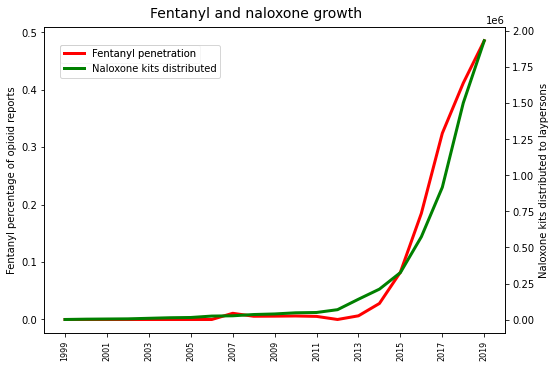

In [38]:
##### FENT-NX GROWTH COMPARISON #####

t = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
t = t.loc[:, :f'{endyear}':4]
fent = t.loc['Fentanyl penetration curve NFLIS']
nxkd = t.loc['Nx kits distributed HR IQVIA']
del t

# Create figure, then plot and label results
fig0, ax0 = plt.subplots(figsize=[7,5], constrained_layout=True)

ax0.plot(fent, color='r', lw=3, label='Fentanyl penetration')

fig0.legend(loc=2, bbox_to_anchor=(0.1, 0.9))

loc = mticker.MultipleLocator(base=2)
ax0.xaxis.set_major_locator(loc)
ax0.tick_params(axis='x', labelsize=8, labelrotation=90)

ax0.set_ylabel('Fentanyl percentage of opioid reports')
fig0.suptitle('Fentanyl and naloxone growth', fontsize=14)

fig0.savefig(f"./FentNxGrowth0.jpg", bbox_inches='tight')

ax1 = ax0.twinx()
ax1.plot(nxkd, color='g', lw=3, label='Naloxone kits distributed')
ax1.set_ylabel('Naloxone kits distributed to laypersons')

loc = mticker.MultipleLocator(base=2)
ax0.xaxis.set_major_locator(loc)
ax0.tick_params(axis='x', labelsize=8, labelrotation=90)


fig0.legend(loc=2, bbox_to_anchor=(0.1, 0.9))

fig0.savefig(f"./FentNxGrowth1.jpg", bbox_inches='tight')

In [ ]:
##### DRF POLICY SCENARIO PLOTS #####

base = 'Cnst' # Set baseline scenario preference
DRFlist = [base] + [cin[:-4] for cin in scenariolist[1:]] # Compile list of scenarios to plot

DRFdict = {} # Initialise container for relevant results
# Add main and sens results for each scenario to container
for scen in DRFlist:
    t = pd.read_csv(f'{baserunname}_final_{scen}_vars.tab', sep='\t', index_col=0)
    s = pd.read_csv(f'{baserunname}_sens_{scen}_clean.tab', sep='\t', index_col=[0,1])
    t.columns = t.columns.astype(float)
    s.columns = s.columns.astype(float)
    for var in projvars: # Add expected values from baserun to sensitivity dataframe
        s.loc[(var, 'EV'), :] = t.loc[var]
    DRFdict[scen] = pd.concat([s.loc[var] for var in projvars], 
                              keys=projvars, names=['Var', 'Perc'])
    del s, t

# Compile new dataframe for scenario results
projtable = pd.concat(DRFdict, names=['Scen', 'Var', 'Perc'])
projtable.to_csv(f'{baserunname}_DRFproj.tab', sep='\t')

p = projtable.loc[:, endyear:] # Subset results to just later years

def proj_plot_template():
    """Lay out basic two-axes figure for outcome plots"""
    fig0, (ax0, ax1) = plt.subplots(1, 2, figsize=[12, 5], constrained_layout=True)
        
    for ax in [ax0, ax1]:
        loc = mticker.MultipleLocator(base=2)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelrotation=90)
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    
    return fig0, ax0, ax1

def fmt_proj_template(fig, ax0, ax1):
    """Format two-axes figure for outcome plots"""
    ax0.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position('right')
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
    ax0.set_ylim(-0.27E05, 5.13E05)
    ax1.set_ylim(-0.2E07, 3.8E07)
    ax0.set_ylabel('Cumulative overdose deaths (thousands)')
    ax1.set_ylabel('Cumulative use disorder person-years (millions)')
    ax0.set_title('Projected cumulative overdose deaths', fontsize=14)
    ax1.set_title('Projected cumulative use disorder person-years', fontsize=14)
    ax0.legend(loc=4)

# Plot baseline scenario, followed by each DRF scenario
b = p.loc[base]
fig0, ax0, ax1 = proj_plot_template()
for ax, var in zip([ax0, ax1], projvars):
    ax.plot(b.loc[var, 'EV'], lw=3, label='Base', color='gray')
    ax.fill_between(b.columns, b.loc[var, 2.5], b.loc[var, 97.5], alpha=0.2, color='gray')
fmt_proj_template(fig0, ax0, ax1)
fig0.savefig(f"./DRF_base.jpg", bbox_inches='tight')

fig1, ax0, ax1 = proj_plot_template()
s = p.loc['DRFSupply']
for ax, var in zip([ax0, ax1], projvars):
    ax.plot(b.loc[var, 'EV'], lw=3, label='Base', color='gray')
    ax.plot(s.loc[var, 'EV'], lw=3, label='Reduced prescribing', color='red')
    ax.fill_between(s.columns, s.loc[var, 2.5], s.loc[var, 97.5], alpha=0.2, color='red')
fmt_proj_template(fig1, ax0, ax1)
fig1.savefig(f"./DRF_supply.jpg", bbox_inches='tight')

fig2, ax0, ax1 = proj_plot_template()
s = p.loc['DRFNx']
for ax, var in zip([ax0, ax1], projvars):
    ax.plot(b.loc[var, 'EV'], lw=3, label='Base', color='gray')
    ax.plot(s.loc[var, 'EV'], lw=3, label='More naloxone', color='blue')
    ax.fill_between(s.columns, s.loc[var, 2.5], s.loc[var, 97.5], alpha=0.2, color='blue')
fmt_proj_template(fig2, ax0, ax1)
fig2.savefig(f"./DRF_Nx.jpg", bbox_inches='tight')

fig3, ax0, ax1 = proj_plot_template()
sa = p.loc['DRFTxDem']
for ax, var in zip([ax0, ax1], projvars):
    ax.plot(b.loc[var, 'EV'], lw=3, label='Base', color='gray')
    ax.plot(sa.loc[var, 'EV'], lw=3, label='Improve Tx access', color='y')
    ax.fill_between(sa.columns, sa.loc[var, 2.5], sa.loc[var, 97.5], alpha=0.2, color='y')
fmt_proj_template(fig3, ax0, ax1)
fig3.savefig(f"./DRF_TxDem.jpg", bbox_inches='tight')

fig4, ax0, ax1 = proj_plot_template()
sb = p.loc['DRFTxCap']
for ax, var in zip([ax0, ax1], projvars):
    ax.plot(b.loc[var, 'EV'], lw=3, label='Base', color='gray')
    ax.plot(sa.loc[var, 'EV'], lw=3, label='Improve Tx access', color='y')
    ax.plot(sb.loc[var, 'EV'], lw=3, label='Increase Tx capacity', color='c')
    ax.fill_between(sb.columns, sb.loc[var, 2.5], sb.loc[var, 97.5], alpha=0.2, color='c')
fmt_proj_template(fig4, ax0, ax1)
fig4.savefig(f"./DRF_TxCap.jpg", bbox_inches='tight')

fig5, ax0, ax1 = proj_plot_template()
sc = p.loc['DRFTxDur']
for ax, var in zip([ax0, ax1], projvars):
    ax.plot(b.loc[var, 'EV'], lw=3, label='Base', color='gray')
    ax.plot(sa.loc[var, 'EV'], lw=3, label='Improve Tx access', color='y')
    ax.plot(sb.loc[var, 'EV'], lw=3, label='Increase Tx capacity', color='c')
    ax.plot(sc.loc[var, 'EV'], lw=3, label='Increase Tx retention', color='springgreen')
    ax.fill_between(sc.columns, sc.loc[var, 2.5], 
                    sc.loc[var, 97.5], alpha=0.2, color='springgreen')
fmt_proj_template(fig5, ax0, ax1)
fig5.savefig(f"./DRF_TxDur.jpg", bbox_inches='tight')

fig6, ax0, ax1 = proj_plot_template()
sd = p.loc['DRFTxAll']
for ax, var in zip([ax0, ax1], projvars):
    ax.plot(b.loc[var, 'EV'], lw=3, label='Base', color='gray')
    ax.plot(sa.loc[var, 'EV'], lw=3, label='Improve Tx access', color='y')
    ax.plot(sb.loc[var, 'EV'], lw=3, label='Increase Tx capacity', color='c')
    ax.plot(sc.loc[var, 'EV'], lw=3, label='Increase Tx retention', color='springgreen')
    ax.plot(sd.loc[var, 'EV'], lw=3, label='All Tx combined', color='green')
    ax.fill_between(sd.columns, sd.loc[var, 2.5], sd.loc[var, 97.5], alpha=0.2, color='green')
fmt_proj_template(fig6, ax0, ax1)
fig6.savefig(f"./DRF_TxAll.jpg", bbox_inches='tight')


In [ ]:
##### DRF FIT-TO-DATA HORIZONTAL PLOT #####

def plot_fits_main_horizontal(fits, mainfits, fitdict, ylabels, errmult=1.96):
    fig0, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(
        2, 3, figsize=[16, 7], sharex=True, constrained_layout=True)
    ax_list = [ax0, ax3, ax1, ax4, ax2, ax5]

    for ax, var in zip(ax_list, mainfits):
        ax.plot(fits.columns, fits.loc[f'SimVar[{var}]'], lw=3, color='#007CBA', zorder=10, label='Simulated')
        ax.scatter(fits.columns[::4], fits.loc[f'DataVar[{var}]'][::4], color='dimgrey', label='Historical')
#         ax.scatter(fits.columns[::4], fits.loc[f'DataVar[{var}]'][::4], color='silver', label='Historical')
        try:
#             ax.errorbar(fits.columns[::4], fits.loc[f'DataVar[{var}]'][::4], 
#                         yerr=fits.loc[f'DataErr[{var}]'][::4] * errmult, fmt='o', color='silver', capsize=3, label='Historical')
            ax.errorbar(fits.columns[::4], fits.loc[f'DataVar[{var}]'][::4], 
                        yerr=fits.loc[f'DataErr[{var}]'][::4] * errmult, fmt='o', color='dimgrey', capsize=3, label='Historical')
        except KeyError:
            pass
        
        ax.set_ylim(0)
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
        
        loc = mticker.MultipleLocator(base=8)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelsize=8)
        
    for ax, label, var in zip([ax0, ax1, ax2], ylabels, mainfits[::2]):
        ax.set_ylabel(label)
        ax.text(0.05, 0.05, fitdict[var], transform=ax.transAxes, fontsize=14, va='bottom')
    
    for ax, label, var in zip([ax3, ax4, ax5], ylabels, mainfits[1::2]):
        ax.set_ylabel(label)
        ax.text(0.05, 0.95, fitdict[var], transform=ax.transAxes, fontsize=14, va='top')
        
    for ax in [ax2, ax5]:
        # Format Y-axis ticks without scientific notation
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
        
    fig0.savefig(f"./{baserunname}_fits_main_horizontal.jpg", bbox_inches='tight')

fitdict['ODHC'] = 'Overdose deaths (heroin \n& illicit synthetics)'

fits = pd.read_csv(f'{baserunname}_fits.tab', sep='\t', index_col=0)
fits = fits.loc[:, :f'{endyear}']
with plt.rc_context({'axes.edgecolor':'gray', 'xtick.color':'gray', 'ytick.color':'gray', 'axes.labelcolor':'gray'}):
    plot_fits_main_horizontal(fits, mainfits, fitdict, fits_y_labels)


In [ ]:
##### CDER BRIEFING PROJECTIONS HORIZONTAL PLOT #####

def plot_fits_proj_horizontal(table, senstable, projfits, fitdict, bounds, 
                              ylabels, basevar='SimVar', endyear='2019'):
    """Plot projections for variables specified in `projfits` list, with 
    CIs specified in `bounds` (multiple CIs allowed) and names and y-
    labels from `fitdict` and `ylabels`; uses SimVar by default but can 
    set `basevar` to RepVar instead to show measurement noise"""
    t, s = table, senstable # For more compact code
    
    # Define main figure and axes
    fig0, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(
        2, 3, figsize=[16, 7], sharex=True, constrained_layout=True)
    ax_list = [ax0, ax3, ax1, ax4, ax2, ax5]

    # Plot sim output and CI bounds
    for ax, var in zip(ax_list, projfits):
        ax.plot(t.columns, t.loc[f'{basevar}[{var}]'], color='#007CBA')
        for bd in bounds:
            ax.fill_between(t.columns, s.loc[f'{basevar}[{var}]', bd[0]], 
                            s.loc[f'{basevar}[{var}]', bd[1]], color='#007CBA', alpha=0.2)
        
        # Add vertical dashed line to mark end of data
        ax.vlines(endyear, 0, 1, transform=ax.get_xaxis_transform(), color='r', ls='dashed')
        
        ax.set_ylim(0) # Anchor y axis on 0
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
        
        loc = mticker.MultipleLocator(base=8)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelsize=8, labelrotation=90)

    for ax, label, var in zip([ax0, ax1, ax2], ylabels, projfits[::2]):
        ax.set_ylabel(label)
        ax.text(0.05, 0.05, fitdict[var], transform=ax.transAxes, fontsize=14, va='bottom')
    
    for ax, label, var in zip([ax3, ax4, ax5], ylabels, projfits[1::2]):
        ax.set_ylabel(label)
        ax.text(0.05, 0.95, fitdict[var], transform=ax.transAxes, fontsize=14, va='top')
        
    for ax in [ax2, ax5]:
        # Format Y-axis ticks without scientific notation
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    
    fig0.savefig(f"./{baserunname}_fits_proj_horizontal.jpg", bbox_inches='tight')

fitdict['ODRT'] = 'Overdose deaths \n(Rx & Rx synthetics)'    
fitdict['ODHC'] = 'Overdose deaths (heroin \n& illicit synthetics)'

t = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
s = pd.read_csv(f'{baserunname}_sens_{basescens[0][:-4]}_clean.tab', sep='\t', index_col=[0,1])

with plt.rc_context({'axes.edgecolor':'gray', 'xtick.color':'gray', 'ytick.color':'gray', 'axes.labelcolor':'gray'}):
    plot_fits_proj_horizontal(t, s, projfits, fitdict, bounds, fits_y_labels, endyear=str(endyear))
    

In [ ]:
##### FENTANYL DEATH ALLOCATION GRAPH #####

# Read in results and compile separate dataframe of just relevant results
table = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
table = table.loc[:, :f'{endyear}']

y0 = table.loc['Total overdose deaths synth base']
y1 = table.loc['Total overdose deaths synth excess']
y2 = table.loc['Total overdose deaths synth heroin NVSS'].interpolate()
y3 = table.loc['Total overdose deaths synth no H NVSS'].interpolate()

del table

fenttime = '2012.5'
soddata = pd.concat([y0, y1, y2, y3], keys=['Base', 'Excess', 'H', 'No H'], axis=1)
soddata['HC'] = soddata['No H'] + soddata['H']
soddata['Syn'] = soddata['Base'] + soddata['Excess']
soddata['Est'] = soddata['No H']
soddata['Est'].loc[fenttime:] = soddata['Base'].loc[fenttime:]

display(soddata)

# Plot actual allocation graph

fig0, ax0 = plt.subplots(figsize=[8, 6], constrained_layout=True)
ax0.set_yscale('log')
ax0.plot(soddata['Base'], color='g', lw=2)
ax0.plot(soddata['Syn'], color='r', lw=2)
ax0.plot(soddata['No H'], color='g', ls='dashed', lw=2)
ax0.plot(soddata['HC'], color='r', ls='dashed', lw=2)
ax0.set_ylim(1000)

ax0.fill_between(soddata.index, soddata['HC'], soddata['No H'], color='r', alpha=0.2)
ax0.fill_between(soddata.index, soddata['No H'], soddata['Est'], color='orange', alpha=0.2)
ax0.fill_between(soddata.index, 0, soddata['Est'], color='g', alpha=0.2)

loc = mticker.MultipleLocator(base=8)
ax0.xaxis.set_major_locator(loc)
ax0.tick_params(axis='x', labelsize=8, labelrotation=90)


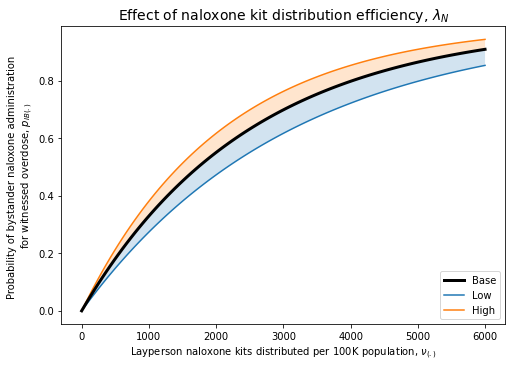

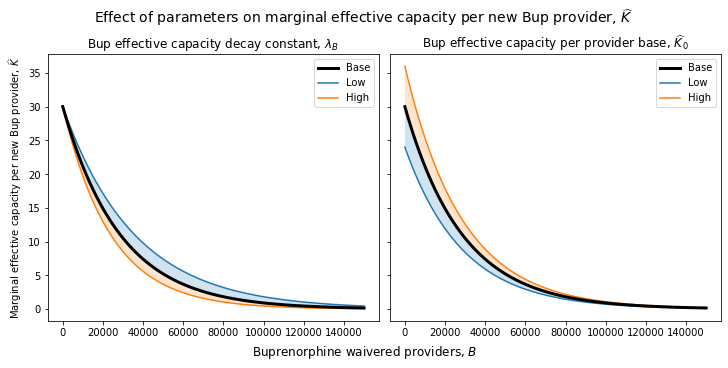

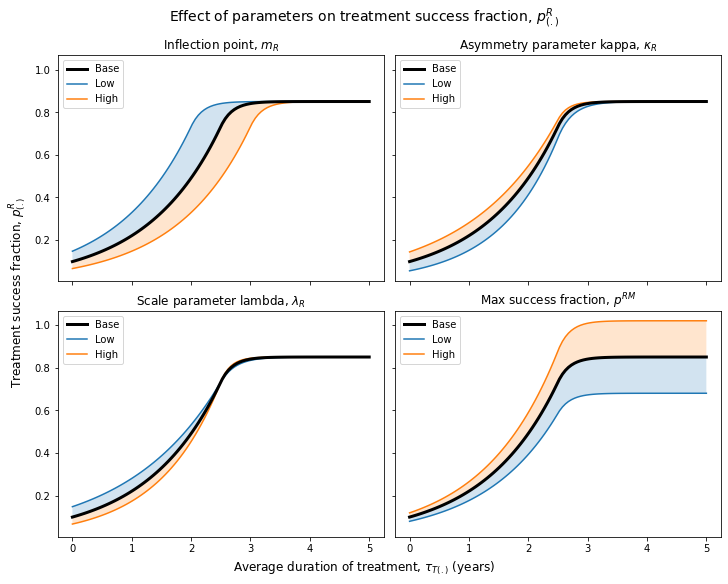

In [7]:
##### ANALYTICAL FUNCTION GRAPHING WITH PARAMETER SENSITIVITY #####

def prob_nx(x, k):
    return 1 - np.exp(-k * x)

def bup_cap_avg(x, k, b):
    return (b * np.exp(-k * x) / -k + b/k)/x

def bup_cap_marginal(x, k, b):
    return b * np.exp(-k * x)

def tx_success(x, i, k, l, m):
    y = np.where(x < i, 
                 k ** 2 / (1 + k ** 2) * np.exp((l / k * (x - i))), 
                 1 - np.exp(-l * k * (x - i)) / (1 + k ** 2)) * m
    return y


def eval_func(func, xrng, args, sensrange=0.2):
    """Umbrella function for calculating results of `func` with `args` 
    over range `xrng`, varying each arg over +/- `sensrange` values"""
    x = np.linspace(*xrng, 100)
    y = []
    for i in range(len(args)):
        args_l = args.copy()
        args_l[i] = args[i] * (1 - sensrange)
        args_h = args.copy()
        args_h[i] = args[i] * (1 + sensrange)
        y.append((func(x, *args), func(x, *args_l), func(x, *args_h)))
    return x, y

def plot_func(x, y, axs):
    """Plot function output from `eval_func`, with +/- arg values"""
    for (m, l, h), ax in zip(y, axs):
        ax.plot(x, m, c='k', lw=3, zorder=10, label='Base')
        ax.plot(x, l, label='Low')
        ax.fill_between(x, m, l, alpha=0.2)
        ax.plot(x, h, label='High')
        ax.fill_between(x, m, h, alpha=0.2)


# Evaluate and plot Nx distribution efficiency function
x, y = eval_func(prob_nx, [0, 6000], [0.0004])
fig0, ax0 = plt.subplots(figsize=[7, 5], constrained_layout=True)
axs = [ax0] # plot_func reads in axs as list
plot_func(x, y, axs)
ax0.set_xlabel(r'Layperson naloxone kits distributed per 100K population, $\nu_{(.)}$')
ax0.set_ylabel('Probability of bystander naloxone administration \n' 
               + r'for witnessed overdose, $p_{IB(.)}$')
ax0.set_title(r'Effect of naloxone kit distribution efficiency, $\lambda_N$', fontsize=14)
ax0.legend(loc=4)
fig0.savefig(f"./Function_ProbNx.jpg", bbox_inches='tight')

# Evaluate and plot marginal bup cap per provider function
x, y = eval_func(bup_cap_marginal, [0, 150000], [3.5e-05, 30])
fig0, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 5], sharey=True, constrained_layout=True)
axs = [ax0, ax1]
plot_func(x, y, axs)
fig0.supxlabel(r'Buprenorphine waivered providers, $B$')
fig0.suptitle(r'Effect of parameters on marginal effective capacity per new Bup provider, '
              r'$\widehatK$', fontsize=14)
ax0.set_ylabel(r'Marginal effective capacity per new Bup provider, $\widehatK$')
ax0.set_title(r'Bup effective capacity decay constant, $\lambda_B$')
ax1.set_title(r'Bup effective capacity per provider base, $\widehatK_0$')
ax0.legend()
ax1.legend()
fig0.savefig(f"./Function_BupCap.jpg", bbox_inches='tight')

# Evaluate and plot Tx duration-success function
x, y = eval_func(tx_success, [0, 5], [2.5, 2.5, 2, 0.85])
fig0, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=[10, 8], sharex=True, sharey=True, 
                                              constrained_layout=True)
axs = [ax0, ax1, ax2, ax3]
plot_func(x, y, axs)
fig0.supxlabel(r'Average duration of treatment, $\tau_{T(.)}$ (years)')
fig0.supylabel(r'Treatment success fraction, $p^R_{(.)}$')
fig0.suptitle(r'Effect of parameters on treatment success fraction, $p^R_{(.)}$', fontsize=14)
ax0.set_title(r'Inflection point, $m_R$')
ax1.set_title(r'Asymmetry parameter kappa, $\kappa_R$')
ax2.set_title(r'Scale parameter lambda, $\lambda_R$')
ax3.set_title(r'Max success fraction, $p^{RM}$')
for ax in axs:
    ax.legend()
fig0.savefig(f"./Function_TxSF.jpg", bbox_inches='tight')

<ipython-input-7-97fcf658d6cb>:7: RuntimeWarning: invalid value encountered in true_divide
  return (b * np.exp(-k * x) / -k + b/k)/x


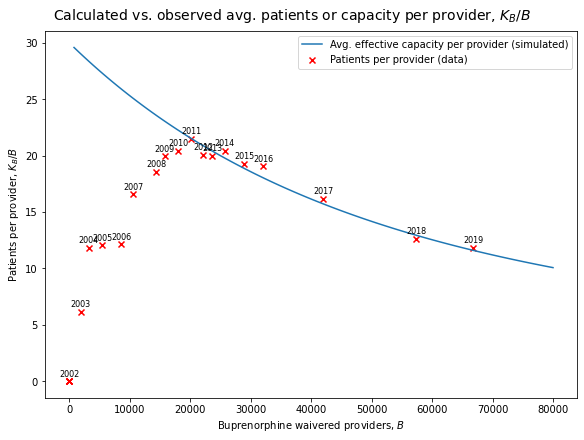

In [21]:
##### BUP PATIENTS PER PROVIDER DATA GRAPHING #####

# Read in and subset necessary data
t = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
t = t.loc[:, :f'{endyear}']

prov = t.loc['Bup providers DATA']
pats = t.loc['Tx annual patients Bup IQVIA TPT']
pppr = t.loc['Bup patients per provider DATA']

# Evaluate and plot average bup cap function and patients per provider data
x, y = eval_func(bup_cap_avg, [0, 80000], [3.5e-05, 30])
fig0, ax0 = plt.subplots(figsize=[8,6], constrained_layout=True)
ax0.plot(x, y[0][0], label='Avg. effective capacity per provider (simulated)')
ax0.scatter(prov, pppr, marker='x', color='r', label='Patients per provider (data)')
for i in t.columns[12:]:
    ax0.annotate(i, (prov[i], pppr[i]), xytext=(-10, 5), textcoords='offset points', fontsize=8)
ax0.set_xlabel(r'Buprenorphine waivered providers, $B$')
ax0.set_ylabel(r'Patients per provider, $K_B/B$')
fig0.suptitle(r'Calculated vs. observed avg. patients or capacity per provider, $K_B/B$', 
              fontsize=14)
ax0.legend()

del t
fig0.savefig(f"./Function_BupData.jpg", bbox_inches='tight')


In [40]:
##### SEND MAIN OUTPUTS TO SUBFOLDER FOR EASY ACCESS #####

os.chdir(basedir)
os.chdir('./Results')
os.makedirs('./ResMain', exist_ok=True)

resmain = ['assm_sens.tab', 'GOF.tab', 'inputs.tab', 'lk_sens.tab', 'params.tab', 
           'proj_changes.tab', 'syndata_means.tab', 'yearvals.tab', 'summary.txt']

for res in resmain:
    copy(f'./{baserunname}_{res}', './ResMain')



In [ ]:
000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [ ]:
table = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
senstable = pd.read_csv(f'{baserunname}_sens_{basescens[0][:-4]}_clean.tab', sep='\t', index_col=[0,1])

rates = ['Developing HUD rate no Rx OUD effective', 'Developing HUD rate with Rx OUD effective', 
         'Developing Rx OUD rate effective', 'Initiation rate heroin with Rx misuse effective', 
         'Initiation rate heroin with Rx OUD effective', 'Initiation rate Rx misuse own Rx effective', 
         'Overdose death rate Rx misuse', 'Overdose death rate Rx OUD no H', 
         'Overdose death rate Rx OUD with H', 'Overdose death rate NDHU', 'Overdose death rate HUD', 
         'Overdose death rate synth NDHU', 'Overdose death rate synth HUD']

for rate in rates:
    plot_projections(table, senstable, rate, bounds)


In [ ]:
##### GENERATE OUTPUTS & FIGURES BASED ON MAIN RUN #####

# Initialise and read in base data
os.chdir(f"{baserunname}_IterCal")
table = pd.read_csv('InputData.tab', sep='\t', index_col=[0,1])
countrylist = list(table.index.levels[1])
print(countrylist)

basename = cf['baserunname']
startdate = datetime.date.fromisoformat('2019-12-31')

# Create string form of sens_durs for inclusion in summary
sens_durs_text = ', '.join(str(dur) for dur in sens_durs[:-1]) + f'and {sens_durs[-1]}'

summarytext = [] # Initialise container for summary output

# First run graphing & results summary for main disease duration value
for i in [main_dur]:
    mainrunname = f'{basename}{i}'
    print(mainrunname)
    
    # Read in main results tab file
    results = pd.read_csv(f'{mainrunname}_results.tab', sep='\t', index_col=0)
    
    # Drop countries in nonequilibrium state
    results[results['end_dpm'] <= 0] = np.NaN
    results[results['end_dpm_mdl'] <= 0] = np.NaN 
    trunc_list = results[results['end_dpm'].isna()].index.tolist() # Identify dropped countries
    results = results[results['end_dpm'].notna()]

    # Summarise results by quantiles, mean and stdev
    quants = results.quantile([0.05, 0.5, 0.95]).T
    quants['Mean'], quants['StDev'] = results.mean().T, results.std().T
    
    params = quants.loc[params_list] # Subset quantiles dataframe to just listed parameters
    
    # Calculate mean & median IQRs for listed parameters
    iqr_vars = [f'{var}_iqr' for var in params_list]
    param_iqrs = results[iqr_vars] # Extract parameter IQR columns from main results tabfile
    param_iqrs.columns = params_list # Rename IQR columns with base parameter names
    params['Mean IQR'], params['Median IQR'] = param_iqrs.mean(), param_iqrs.median()
    
    # Export summarised results to quantiles and params files
    results.to_csv(f'{mainrunname}_results_trunc.tab', sep='\t')
    quants.loc[tablekeys].to_csv(f'./{mainrunname}_quantiles.tab', sep='\t')
    results[params_list].to_csv(f'{mainrunname}_params_full.tab', sep='\t')
    params.to_csv(f'{mainrunname}_params_summary.tab', sep='\t')
    
    # Convert specified dates from numeric to datetime
    enddate = startdate + datetime.timedelta(days=len(table.columns)-1)
    eqmdate = startdate + datetime.timedelta(days=eqtime)
    eardate = startdate + datetime.timedelta(days=earlytime)
    
    # Summarise MIQRs for full IQRs list
    miqrs = [str(results[f'{var}_iqr'].mean()) for var in iqr_list]
    miqr_text = '\t'.join(iqr_list) # IQR variable names
    miqr_vals = '\t'.join(miqrs) # IQR variable values
    
    # Calculate correlation & log-correlation for DPM and g(D)
    corr = pearsonr(results['end_gdn'], results['end_dpm'])
    logcorr = pearsonr(results['end_gdn'], np.log10(results['end_dpm']))
    
    # Calculate log-correlation for mobility and DPM
    mobdf = res.filter(['mob_rr', 'mob_wk', 'mob_avg', 'mean_dpm'])
    mobdf.dropna(axis=0, inplace=True) # Drop countries missing mobility data
    rrcorr = pearsonr(mobdf['mob_rr'], np.log10(mobdf['mean_dpm']))
    wkcorr = pearsonr(mobdf['mob_wk'], np.log10(mobdf['mean_dpm']))
    avgcorr = pearsonr(mobdf['mob_avg'], np.log10(mobdf['mean_dpm']))
    
    # Compile summary output as text list
    summarytext.extend(
        [f"Total countries\t{len(countrylist)}\n", 
         f"Total population\t{results['population'].sum()}\n", 
         f"Nonequilibrium countries\t{len(trunc_list)}\n", 
         f"Equilibrium countries\t{len(results.index)}\n", 
         f"Start date\t{startdate.isoformat()}\t\tMin cumulative cases\t{min_cases}\n", 
         f"End date\t{enddate.isoformat()}\t\tMin datapoints\t{min_datapoints}\n", 
         f"Eqm date\t{eqmdate.isoformat()}\t\tStartpoint cases\t{start_cases}\n", 
         f"Early date\t{eardate.isoformat()}\n", 
         f"Disease duration\t{i}\n", 
         f"Initial responsiveness\t{np.exp(-results['alpha 0'].median())}\n", 
         f"Final responsiveness\t{np.exp(-results['end_alpha'].median())}\n", 
         f"Correlation\t{corr[0]}\t{corr[1]}\n", 
         f"LogCorrelation\t{logcorr[0]}\t{logcorr[1]}\n", 
         f"WorkMobility Correlation\t{wkcorr[0]}\t{wkcorr[1]}\n", 
         f"RRMobility Correlation\t{rrcorr[0]}\t{rrcorr[1]}\n", 
         f"AvgMobility Correlation\t{avgcorr[0]}\t{avgcorr[1]}\n", 
         f"Historical window\t{hist_window}\n", 
         f"eq_gdn MNIQR\t{results['eq_gdn_niqr'].median()}\n", 
         f"eq_dpm MNIQR\t{results['eq_dpm_niqr'].median()}\n", 
         f"end_gdn MNIQR\t{results['end_gdn_niqr'].median()}\n", 
         f"end_dpm MNIQR\t{results['end_dpm_niqr'].median()}\n", 
         f"mean MAEOM\t{results['maeom'].mean()}\n", 
         f"mean MAPE\t{results['mape'].mean()}\n", 
         f"mean r2\t{results['r2'].mean()}\n", 
         f"\t{miqr_text}\n", 
         f"MIQR\t{miqr_vals}\n", 
         f"List of nonequilibrium countries\t{', '.join(trunc_list)}\n", 
         f"MCLIMIT\t{mcsettings['MCLIMIT']}\n", 
         f"MCBURNIN\t{mcsettings['MCBURNIN']}\n", 
         f"Sens days\t{sens_durs_text}\n"
         ])

    # Plot various figures
    plot_scatter(results, 'end_gdn', 'end_dpm')
    plot_intervals(results, 'end_gdn', 'end_dpm', ci=(0.05, 0.95))
    plot_scatter_basic(results)
    plot_scatter_mobility(results)
    plot_sensitivity(mainrunname, sens_vars, sens_mults)
    plot_country_fits(c_list, c_names)
    plot_regression(mainrunname)
    plot_chg_dpm(results, 'chg_dpm', delta, threshold=0.005, avg='median')

    # Plot all-country infection fits
    infdf = pd.read_csv(f'{mainrunname}_infections.tab', sep='\t', index_col=[0,1])
    plot_fits_full(infdf, 'inf_exp', 'inf_data', 'infection')
    

In [ ]:
import regex

text = """1 <= foo bar baz = 2 <= 3
 :NI=5
 :PENG = 7
 42 <= foo = 50 <= 90
 bar = 27
 NI PENG NEEWOM = 1000
 2 <= PENG2 = 3 <= 4
 PENG PENG PENG
 PENG=5
 NI = 3
 foo3 bar = 7
 :fo4o=2"""

lines = text.strip().split('\n')

def find(key):
    for line in lines:
        m = regex.search(r'[a-z0-9_]+(?: +[a-z0-9_]+)*', line, regex.I)
        if m:
            name = m[0]
            if key == name:
                print(line)
                return True

print(find('NEEWOM'))

In [ ]:
### REGEX KEYS

# Identify entire line containing VARNAME as name
.*(?<=[^\w ]|\n)\s?VARNAME\s?(?=[^\w ]).*
# Identify only numeric string corresponding to VARNAME as name
(?<=([^\w ]|\n)\s?VARNAME\s?=)\s*-?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)?

x = '137.5'
if '.' in x:
    y = float(x)
else:
    y = int(x)
y

In [ ]:
000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [ ]:
### OD Death rates comparative plot

t = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
t = t.loc[:, :'2025']
s = pd.read_csv(f'{baserunname}_sens_{basescens[0][:-4]}_clean.tab', sep='\t', index_col=[0,1])
s = s.loc[:, :'2025.0']

ODrates = ['Overdose death rate Rx misuse', 'Overdose death rate NDHU', 'Overdose death rate Rx OUD no H', 
           'Overdose death rate Rx OUD with H', 'Overdose death rate HUD']
ODlabs = ['Rx misuse', 'Heroin misuse', 'Rx OUD (no H use)', 'Rx OUD + H use', 'HUD']
bds = [2.5, 97.5]
year = '2025.0'

meds = [s.loc[(rate, 50.0), year] for rate in ODrates]
lows = [s.loc[(rate, bds[0]), year] for rate in ODrates]
high = [s.loc[(rate, bds[1]), year] for rate in ODrates]

errs = ([m - l for m, l in zip(meds, lows)], [h-m for h, m in zip(high, meds)])

fig0, ax0 = plt.subplots(figsize=[4, 4], constrained_layout=True)
ax0.errorbar(meds, ODlabs, xerr=errs, fmt='o')
# ax0.set_xscale('log')


def plot_fits_proj_full(baserunname, basescens, fullfits, fitdict, bounds, basevar='SimVar', noisevar=None):
    
    fig0, axs = plt.subplots(4, 4, figsize=[14, 10], sharex=True, constrained_layout=True)
    
    for ax, var in zip(axs.flatten(), fullfits):
        for scen in basescens:
            t = pd.read_csv(f'{baserunname}_final_{scen[:-4]}_vars.tab', sep='\t', index_col=0)
            s = pd.read_csv(f'{baserunname}_sens_{scen[:-4]}_clean.tab', sep='\t', index_col=[0,1])
        
            ax.plot(t.columns, t.loc[f'{basevar}[{var}]'])
            for bd in bounds:
                if noisevar:
                    ax.fill_between(t.columns, s.loc[f'{noisevar}[{var}]', bd[0]], 
                                    s.loc[f'{noisevar}[{var}]', bd[1]], alpha=0.2, color='grey')
                ax.fill_between(t.columns, s.loc[f'{basevar}[{var}]', bd[0]], 
                                s.loc[f'{basevar}[{var}]', bd[1]], alpha=0.2)
        
        ax.set_title(fitdict[var], fontsize=9)
                
        ax.vlines('2019', 0, 1, transform=ax.get_xaxis_transform(), color='r', ls='dashed')
        
        ax.set_ylim(0)
        
        loc = mticker.MultipleLocator(base=8)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelsize=7, labelrotation=90)

        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3))
        ax.yaxis.offsetText.set_fontsize(7)
        ax.tick_params(axis='y', labelsize=7)

    return fig0

fig1 = plot_fits_proj_full(baserunname, basescens, fullfits, fitdict, bounds)
fig1.legend()
fig1.savefig(f"./{baserunname}_fits_proj_full.jpg", bbox_inches='tight')


In [ ]:
##### FUNCTION DEFINITIONS FOR PLOTTING FIGURES FROM RESULTS #####

def plot_intervals(res, a, b, ci=(0.05, 0.95), avg='mode'):
    """Plots parameter `a` and `b` values for each country, with error 
    bars indicating credible interval as specified in `ci`, selecting 
    main data values based on `avg`='mode' or 'median'"""
    # Set results to use as median or default to modal (most likely) value
    if avg == 'median':
        res_a, res_b = res[f'{a}_0.5'], res[f'{b}_0.5']
    else:
        res_a, res_b = res[a], res[b]
        
    # Calculate error bars based on upper and lower bounds in `ci`
    eq_gdn_err = (res_a - res[f'{a}_{ci[0]}'], res[f'{a}_{ci[1]}'] - res_a)
    eq_dpm_err = (np.log10(res_b) - np.log10(res[f'{b}_{ci[0]}']), 
                  np.log10(res[f'{b}_{ci[1]}']) - np.log10(res_b))

    # Create figure and plot points with error bars
    fig0, (ax0, ax1) = plt.subplots(2, 1, figsize=[12, 5], constrained_layout=True)
    ax0.errorbar(res.index, res_a, yerr=eq_gdn_err, fmt='o')
    ax1.errorbar(res.index, np.log10(res_b), yerr=eq_dpm_err, fmt='o')
    
    # Assign titles and X-axis labels
    ax0.set_title('Quasi-equilibrium relative contact rate')
    ax1.set_title('Log quasi-equilibrium death rate')
    ax0.tick_params(axis='x', labelsize=8, labelrotation=90)
    ax1.tick_params(axis='x', labelsize=8, labelrotation=90)
    
    # Turn on Y-axis gridlines
    ax0.grid(True, axis='y')
    ax1.grid(True, axis='y')

    fig0.savefig(f"./{baserunname}_Intervals.jpg")


def plot_chg_dpm(res, a, delta, ci=(0.05, 0.95), threshold=0.005, avg='mode'):
    """Plots end-period change in DPM `a`, averaged over time `delta`, 
    with error bars indicating credible interval as specified in `ci`, 
    for countries with absolute change greater than `threshold`, 
    selecting main data values based on `avg`='mode' or 'median'"""
    
    # Set results to use as median or default to modal (most likely) value
    if avg == 'median':
        sort_res = res.sort_values(f'{a}_0.5', ascending=False)
        sort_res_a = sort_res[f'{a}_0.5']
    else:
        sort_res = res.sort_values(a, ascending=False)
        sort_res_a = sort_res[a]

    # Calculate threshold indices and error bars
    sort_res = sort_res[abs(sort_res_a) > threshold]
    sort_res_h = sort_res_a[sort_res_a > threshold]
    sort_res_l = sort_res_a[sort_res_a < -threshold]
    sort_res_a = sort_res_a[abs(sort_res_a) > threshold]
    chg_dpm_err = (sort_res_a - sort_res[f'{a}_{ci[0]}'], 
                   sort_res[f'{a}_{ci[1]}'] - sort_res_a)

    # Create two copies of plot for use with broken axis
    fig0, (ax0, ax1) = plt.subplots(1, 2, figsize=[12, 4], sharey=True, tight_layout=True)
    ax0.errorbar(sort_res_a.index, sort_res_a, yerr=chg_dpm_err, fmt='o')
    ax1.errorbar(sort_res_a.index, sort_res_a, yerr=chg_dpm_err, fmt='o')

    # Split X-axis and set Y-zoom
    ax0.set_xlim(xmax=sort_res_h.index[-1])
    ax1.set_xlim(xmin=sort_res_l.index[0])
    ax0.set_ylim(-0.1, 0.1)
    ax1.set_ylim(-0.1, 0.1)

    # Remove internal spines and ticks
    ax0.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.yaxis.tick_right()

    # Set up X-axis labels, Y-axis gridlines, and figure title
    ax0.tick_params(axis='x', labelsize=8, labelrotation=90)
    ax1.tick_params(axis='x', labelsize=8, labelrotation=90)
    ax0.grid(True, axis='y')
    ax1.grid(True, axis='y')
    fig0.suptitle(r'Trends in quasi-equilibrium death rates $d^{eq}_{NM}$', fontsize=12)

    # Set up broken axis diagonal slashes
    d = .015 # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
    ax0.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
    ax0.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    kwargs.update(transform=ax1.transAxes) # switch to the bottom axes
    ax1.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
    ax1.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
   
    fig0.savefig(f"./{baserunname}_ChgDpm.jpg")

    
def plot_scatter(res, x, y):
    """Plots double-histogram scatterplot of country results for `x` and 
    `y` (by default, g(D) and DPM), with `y` on log-scale"""
    # Create main figure
    fig0, ax0 = plt.subplots(figsize=[8, 8], constrained_layout=True)
    
    area = (1e-03 * np.sqrt(res['population'])) ** 2 # Assign area based on population
    
    # Helper function to drop indices with negative x or y values from dataframe
    def drop_negs(df):
        posdf = df[res[x] > 0]
        posdf = posdf[res[y] > 0]
        return posdf
    
    # Drop negatives from results & area / colour keys  
    res_x, res_y, area, gdp = [drop_negs(df) for df in [res[x], res[y], area, res['gdp_per_cap']]]
    
    ax0.set_yscale('log') # Set Y-axis to log scale
    
    # Plot main scatterplot with GDP color scale and area proportional to population
    ax0.scatter(res_x, res_y, s=area, alpha=0.5)
    
    # Label points with country abbreviations
    for i in res_x.index:
        ax0.annotate(i, (res_x[i], res_y[i]), fontsize=8)
    
    ### THIS SECTION FOR AXIS HISTOGRAMS IF DESRIED ###
    """
    # Create axes for X- and Y-axis histograms
    divider = make_axes_locatable(ax0)
    ax_histx = divider.append_axes('top', 1.5, pad=0.1, sharex=ax0)
    ax_histy = divider.append_axes('right', 1.5, pad=0.1, sharey=ax0)

    # Remove ticks & labels on axes abutting main plot
    ax_histx.xaxis.set_tick_params(labelbottom=False)
    ax_histy.yaxis.set_tick_params(labelleft=False)
    
    # Plot X- and Y-axis histograms, correcting Y-axis hist for log scale
    xhist = ax_histx.hist(res_x, bins=20)
    ax_histy.set_yscale('log') # Set Y-axis to log scale
    yhist = np.histogram(res_y, bins=20) # Create temporary histogram to calculate bin limits
    logbins = np.logspace(np.log10(yhist[1][0]),np.log10(yhist[1][-1]),len(yhist[1]))
    yhist = ax_histy.hist(res_y, bins=logbins, orientation='horizontal')
    
    # Format Y-axis ticks as decimals instead of scientific notation
    ax_histy.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y)))
    """
    # Set labels and titles
    ax0.set_xlabel(r'Quasi-equilibrium normalized contact rate $g^{eq}$')
    ax0.set_ylabel(r'Quasi-equilibrium death rate per million $d^{eq}_{NM}$')
    fig0.suptitle('Expected deaths vs. normalized contacts', fontsize=14)
    
    fig0.savefig(f"./{baserunname}_Scatter.jpg", bbox_inches='tight')


def plot_scatter_basic(res):
    """Plot scatterplot of log(mean DPM) against average Re"""
    # Create figure and scatterplot
    fig0, ax0 = plt.subplots(figsize=[7, 7], constrained_layout=True)
    ax0.set_yscale('log') # Set Y-axis to log scale
    ax0.scatter(res['avg_Re'], res['mean_dpm'], alpha=0.5)
    
    # Label points with country abbreviations
    for i in res.index:
        ax0.annotate(i, (res['avg_Re'][i], res['mean_dpm'][i]), fontsize=8)
    
    # Format Y-axis ticks without scientific notation
    ax0.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax0.yaxis.get_major_formatter().set_scientific(False)
    
    # Set labels and titles
    ax0.set_xlabel(r'Effective reproduction rate $R_e$')
    ax0.set_ylabel(r'Average death rate per million $d_{NM}$')
    ax0.set_xlim(0.5, 1.5) # Widen X-axis for clearer visual clustering of Re values
    fig0.suptitle('Reported death rates vs. effective reproduction rates', fontsize=14)
    
    fig0.savefig(f"./{baserunname}_Scatter_Basic.jpg", bbox_inches='tight')


def plot_scatter_mobility(res):
    """Plot scatterplots of log(mean DPM) against change in mobility (as 
    average, workplace, and retail & recreation visits)"""
    # Loop through averge, workplace, and R&R plots
    for sfx, lbl in zip(['avg', 'wk', 'rr'], 
                        ['', ' (workplace)', ' (retail & recreation)']):
        # Create figure and scatterplot
        fig0, ax0 = plt.subplots(figsize=[8, 8], constrained_layout=True)
        area = (1e-03 * np.sqrt(res['population'])) ** 2 # Assign area based on population
        ax0.set_yscale('log')
        ax0.scatter(res[f'mob_{sfx}'], res['mean_dpm'], s=area, alpha=0.5)

        # Label points with country abbreviations
        for i in res.index:
            ax0.annotate(i, (res[f'mob_{sfx}'][i], res['mean_dpm'][i]), fontsize=8)

        # Format Y-axis ticks without scientific notation
        ax0.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax0.yaxis.get_major_formatter().set_scientific(False)

        # Set labels and titles
        ax0.set_xlabel(r'% change in daily visits')
        ax0.set_ylabel(r'Average death rate per million $d_{NM}$')
        fig0.suptitle(f'Reported death rates vs. % change in daily visits {lbl}', fontsize=14)

        fig0.savefig(f"./{baserunname}_Scatter_Mob_{sfx}.jpg", bbox_inches='tight')
    
    
def plot_country_fits(c_list, c_names):
    """Plot four illustrative country-level graphs for countries in 
    `c_list` showing infections (sim and data) and deaths (data) on one 
    plot, and responsiveness and g(D) on another, for each country"""
    
    res_list = [] # Initialise container for relevant data

    # Read country results files and extract necessary data series
    for c in c_list:
        c_res = pd.read_csv(f'./{baserunname}/{c}/{baserunname}_{c}_MC.tab', sep='\t', 
                            index_col=0, error_bad_lines=False)

        #Change X-axis from numeric to datetime
        dates = pd.to_datetime('2019-12-31') + pd.to_timedelta(c_res.columns.astype(int), unit='D')

        res_list.append([dates, # Dates for X-axis
                         c_res.loc[f'Mu[{c}]'], # Infections (model)
                         c_res.loc[f'DataFlowOverTime[{c}]'], # Infections (data)
                         c_res.loc[f'DeathsOverTime[{c}]'], # Deaths (data)
                         c_res.loc[f'alpha[{c}]'], # Responsiveness
                         c_res.loc[f'g death[{c}]']]) # Contact reduction g(D)

    # Create main figure and axes
    fig0 = plt.figure(figsize=[12, 12], constrained_layout=True)
    gs = fig0.add_gridspec(4, 2, height_ratios=[2.5,1,2.5,1]) # Specify size ratios with gridspec
    (ax0, ax4), (ax1, ax5), (ax2, ax6), (ax3, ax7) = gs.subplots(sharex=True) # Note order of axes

    # Compile axes into list by country, for ease of country-by-country plotting
    ax_list = [(ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)]
    
    # Set labels for left-hand axes only, and figure title
    ax0.set_ylabel(r'Daily new cases (total) $r_{IM}$ &' + '\n' + r'deaths per million $d_{NM}$')
    ax1.set_ylabel(r'Responsiveness $\alpha$ &' + '\n' + r'relative contact rate $g(D)$')
    ax2.set_ylabel(r'Daily new cases (total) $r_{IM}$ &' + '\n' + r'deaths per million $d_{NM}$')
    ax3.set_ylabel(r'Responsiveness $\alpha$ &' + '\n' + r'relative contact rate $g(D)$')
    fig0.suptitle('Illustrative country fits to data', fontsize=14)

    # Loop through pair of axes for each country
    for i, axs in enumerate(ax_list):
        # Plot infection (model and data) lines
        line0, = axs[0].plot(res_list[i][0], res_list[i][1], color='blue', 
                             label=r'Cases $r_{IM}$ (model)')
        line1, = axs[0].plot(res_list[i][0], res_list[i][2], color='blue', linestyle='dotted', 
                             label=r'Cases $r_{IM}$ (data)')
        axb = axs[0].twinx() # Create twinned axes for deaths
        axc = axs[1].twinx() # Create twinned axes for g(D)
        
        # Plot deaths (data), responsiveness, and g(D) lines
        line2, = axb.plot(res_list[i][0], res_list[i][3], color='purple', linestyle='dotted', 
                          label=r'Deaths $d_{NM}$ (data)')
        line3, = axs[1].plot(res_list[i][0], res_list[i][4], color='red', 
                             label=r'Responsiveness $\alpha$')
        line4, = axc.plot(res_list[i][0], res_list[i][5], color='orange', 
                          label=r'Contacts relative to normal $g(D)$')
        axs[0].set_title(c_names[i], y=0.92) # Label with country full names from `c_names`
        axs[1].set_ylim(0) # Ensure responsiveness & g(D) plot starts at 0

    # Set X-axis tick labels to months for bottom axes
    months = mdates.MonthLocator()
    months_fmt = mdates.DateFormatter('%b')
    ax3.xaxis.set_major_locator(months)
    ax3.xaxis.set_major_formatter(months_fmt)
    ax7.xaxis.set_major_locator(months)
    ax7.xaxis.set_major_formatter(months_fmt)

    # Set up and display legend
    handles = [line0, line1, line2, line3, line4]
    labels = [line.get_label() for line in handles]
    fig0.legend(handles, labels, loc=9, bbox_to_anchor=(0.5, 0), ncol=5)
    
    fig0.savefig(f"./{baserunname}_Country_Fits.jpg", bbox_inches='tight')
    

def plot_regression(baserunname):
    """Plot two-panel figure with death regression coefficient over time 
    and last-day actual deaths against calculated equilibrium deaths"""
    
    # Read in deaths data and regression coefficients from processed results
    dthdf = pd.read_csv(f'{baserunname}_deaths.tab', sep='\t', index_col=['field', 'iso_code'])
    regdf = pd.read_csv(f'{baserunname}_regression.tab', sep='\t', index_col=0)
    
    # Extract and clean last-day death data
    X_final, Y_final = dthdf.loc['eqDeath'].iloc[:, -1], dthdf.loc['dpm'].iloc[:, -1]
    X_final[X_final <= 0] = np.NaN
    Y_final[Y_final <= 0] = np.NaN

    #Change X-axis from numeric to datetime
    dates = pd.to_datetime('2019-12-31') + pd.to_timedelta(regdf.index.astype(int), unit='D')

    # Create figure and plot regression coefficient over time on first axes
    fig0, (ax0, ax1) = plt.subplots(1, 2, figsize=[12, 6], constrained_layout=True)
    ax0.plot(dates, regdf['RLM'])
    
    # Plot log-log scatterplot of deaths on second axes
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.scatter(X_final, Y_final)
    
    # Turn off scientific notation on X- and Y-axis
    ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax1.xaxis.get_major_formatter().set_scientific(False)
    ax1.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax1.yaxis.get_major_formatter().set_scientific(False)
    
    # Plot regression line for last day on scatterplot
    linespace = np.linspace(X_final.min(), X_final.max(), 20)
    slope_final = regdf['RLM'].iloc[-1] # Get slops from last day regression coefficient
    ax1.plot(linespace, linespace * slope_final, color='purple', 
             linestyle='dotted', label=f'{slope_final}')

    # Set X-axis tick labels to months
    months = mdates.MonthLocator()
    months_fmt = mdates.DateFormatter('%b')
    ax0.xaxis.set_major_locator(months)
    ax0.xaxis.set_major_formatter(months_fmt)

    # Set labels and titles, including annotation showing regression line slope
    ax0.set_ylabel('Regression coefficient')
    ax1.set_xlabel(r'Projected quasi-equilibrium deaths per million $d^{eq}_{NM}$')
    ax1.set_ylabel(r'Actual current deaths per million $d_{NM}$')
    ax0.set_title(r'A) Regression coefficient for $d_{NM}$ vs. $d^{eq}_{NM}$')
    ax1.set_title(r'B) Last day $d_{NM}$ vs. $d^{eq}_{NM}$ with regression line')
    ax1.text(100, 100, f'b = {"{:.3f}".format(slope_final)} ', horizontalalignment='right')

    fig0.savefig(f"./{baserunname}_EqDeath_Reg.jpg", bbox_inches='tight')
    

def plot_fits_full(res, a, b, lab):
    """Plot fits for every country in results dataframe `res` between 
    variables `a` and `b` (usually sim output and data), identified with 
    label `lab` (WARNING: takes a while)"""
    #Change x-axis from numeric to datetime
    dates = pd.to_datetime('2019-12-31') + pd.to_timedelta(res.columns.astype(int), unit='D')
    res.columns = dates

    # Create figure - UPDATE subplot number and size based on no. of countries
    fig0, axs = plt.subplots(12, 10, figsize=[12, 12], sharex=True, constrained_layout=True)

    # Extract list of countries to plot from dataframe
    c_list = res.index.levels[1]

    # Extract relevant results for variables `a` and `b`
    res_a, res_b = res.loc[a], res.loc[b]

    # Delete any excess axes
    for i in range(len(axs.flatten())-len(c_list)):
        fig0.delaxes(axs.flatten()[len(c_list) + i])

    # Loop over list of countries to plot each one
    for i, c in enumerate(c_list):
        ax = axs.flatten()[i] # Identify current axes from flattened list
        
        # Plot each variable and set title
        ax.plot(res_a.loc[c], color='blue')
        ax.plot(res_b.loc[c], color='red', linestyle='dotted')
        ax.set_title(c, fontsize=7)
        
        # Add Y-axis ticks and labels, scaled appropriately
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3))
        ax.yaxis.offsetText.set_fontsize(6)
        ax.tick_params(axis='y', labelsize=6)

        # Set X-axis tick labels to months
        months = mdates.MonthLocator(interval=3)
        months_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(months_fmt)
        ax.tick_params(axis='x', labelsize=6, labelrotation=90)

    # Add title based on specified `lab`
    fig0.suptitle(f'Simulated daily {lab}s (blue) and true reported {lab} rate (red) \
                  \n(7-day rolling average) for all countries', fontsize=14)

    fig0.savefig(f"./{baserunname}_CtyFitsFull.jpg")

    
def plot_sensitivity(baserunname, sens_vars, sens_mults):
    """Plot illustrative run parameter sensitivity analysis results"""
    # Read in base run and sensitivity Re and DPM results
    res = pd.read_csv(f'./{baserunname}_sens_base.tab', sep='\t', index_col=0)
    redf = pd.read_csv(f'./{baserunname}_sens_Re.tab', sep='\t', index_col=0)
    dthdf = pd.read_csv(f'./{baserunname}_sens_Death.tab', sep='\t', index_col=0)

    # Set up run names
    sfxs = [str(mult).replace('.','') for mult in sens_mults]
    colnames = [f'{baserunname}_sens_{sens_vars[0][0]}_{sfx}' for sfx in sfxs]

    #Change X-axis from numeric to datetime, for base and sensitivity runs
    basedates = pd.to_datetime('2019-12-31') + pd.to_timedelta(res.columns.astype(int), unit='D')
    dates = pd.to_datetime('2019-12-31') + pd.to_timedelta(redf.columns.astype(int), unit='D')

    # Create figure and main axes, and twinned axes for each
    fig0, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=[12, 10], constrained_layout=True)
    ax0b, ax1b, ax2b, ax3b = [ax.twinx() for ax in [ax0, ax1, ax2, ax3]]

    # Plot lines for base case
    ax0.plot(basedates, res.loc['Re'], color='blue', label='Re')
    ax0b.plot(basedates, res.loc['Deaths'], color='red', label='Deaths')

    for ax, axb in zip([ax1, ax2, ax3], [ax1b, ax2b, ax3b]):
        # Plot lines for Re
        line0, = ax.plot(dates, redf.loc[f'{colnames[1]}'], color='blue', 
                         label=r'Effective reproduction rate $R_e$ (base)')
        line1, = ax.plot(dates, redf.loc[f'{colnames[0]}'], color='blue', 
                         linestyle='dotted', label=r'$R_e$ (0.5x)')
        line2, = ax.plot(dates, redf.loc[f'{colnames[2]}'], color='blue', 
                         linestyle='dashed', label=r'$R_e$ (2x)')
        # Plot lines for death rate
        line3, = axb.plot(dates, dthdf.loc[f'{colnames[1]}'], color='red', 
                          label=r'Daily death rate per million $d_{NM}$ (base)')
        line4, = axb.plot(dates, dthdf.loc[f'{colnames[0]}'], color='red', 
                          linestyle='dotted', label=r'$d_{NM}$ (0.5x)')
        line5, = axb.plot(dates, dthdf.loc[f'{colnames[2]}'], color='red', 
                          linestyle='dashed', label=r'$d_{NM}$ (2x)')

    # Set axes and figure titles
    ax0.set_title('A) Base run showing quasi-equilibrium phase')
    ax1.set_title(r'B) Base effective contact rate $\beta_0$')
    ax2.set_title(r'C) Responsiveness $\alpha$')
    ax3.set_title(r'D) Time to perceive risk $\lambda$')
    fig0.suptitle('Sensitivity of basic epidemic dynamics to key parameters', fontsize=14)

    # Set X-axis tick labels to years and set Y-axis limits
    years = mdates.YearLocator()
    years0 = mdates.YearLocator() # Secondary locator for two-year window
    years_fmt = mdates.DateFormatter('%Y')
    ax0.xaxis.set_major_locator(years0)
    ax0.xaxis.set_major_formatter(years_fmt)
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(years_fmt)
        ax.set_ylim(ymin=0, ymax=2.1)

    ax0.set_ylim(ymin=0, ymax=2.1)
    ax1b.set_ylim(ymax=10)
    ax2b.set_ylim(ymax=5)
    ax3b.set_ylim(ymax=5)

    # Set up and display legend
    handles = [line0, line1, line2, line3, line4, line5]
    labels = [line.get_label() for line in handles]
    fig0.legend(handles, labels, loc=9, bbox_to_anchor=(0.5, 0), ncol=2)

    fig0.savefig(f"./{baserunname}_Sensitivity.jpg", bbox_inches='tight')